In [2]:
import numpy as np
import pandas as pd
from sublimpy import utils, tidy
import altair as alt
alt.data_transformers.enable('json')
from scipy import interpolate

import swifter
import xarray as xr
import tqdm
import matplotlib.pyplot as plt

In [3]:
HEIGHTS = [1,3,10]
HORIZ_GRID_SPACING = 50
VERT_GRID_SPACING = 20
# start_date = '20221130'
# end_date = '20230509'
start_date = '20221101'
end_date = '20230619'

data_start_date = '20221130'
data_cutoff_date = '20230508'

## PARAMETERS FOR SOS DATA
# streamwise coordinates
sos_tidy_fn = f"tidy_df_{start_date}_{end_date}_planar_fit_multiplane.parquet"
# slope relative local earth coodinates
# sos_tidy_fn = f"tidy_df_{start_date}_{end_date}_planar_fit.parquet"
# seemingly local earth coodinates
# sos_tidy_fn = f"tidy_df_{start_date}_{end_date}_noplanar_fit.parquet"

## PARAMETERS FOR SPLASH DATA
# download dir
avp_download_dir = "/Users/elischwat/Development/data/sublimationofsnow/asfs/ASFS-50_Level2_SPLASH2021-2023/"
kps_download_dir = "/Users/elischwat/Development/data/sublimationofsnow/asfs/ASFS-30_Level2_SPLASH2021-2023/"

ftp_url = 'ftp1.esrl.noaa.gov'
# Avery Picnic product
avp_url = f'Observations/Campaigns/SPLASH/asfs50/2_level_ingest/'
# Kettle Ponds product
kps_url = f'Observations/Campaigns/SPLASH/asfs30/2_level_ingest/'

In [4]:
print(len(pd.read_parquet(f"tidy_df_{start_date}_{end_date}_planar_fit_multiplane.parquet")))
print(len(pd.read_parquet(f"tidy_df_{start_date}_{end_date}_planar_fit.parquet")))
print(len(pd.read_parquet(f"tidy_df_{start_date}_{end_date}_noplanar_fit.parquet")))

9580032
9568944
9591120


# Open data

## SOS

In [5]:
tidy_df = pd.read_parquet(sos_tidy_fn)

# Convert data timezone to local and clean up data on the ends
# convert time column to datetime
tidy_df['time'] = pd.to_datetime(tidy_df['time'])
tidy_df = utils.modify_df_timezone(tidy_df, 'UTC', 'US/Mountain')
# limit data to our dates of interest, based on continuous snow cover at Kettle Ponds

tidy_df = tidy_df.set_index('time').sort_index().loc[data_start_date:data_cutoff_date].reset_index()

## SPLASH

In [6]:

# Get the list of files in the directory
file_list = os.listdir(kps_download_dir)

file_list = [f for f in file_list if 'sledmet.asfs30.level2.0.1min.' in f]

# Sort the file list
file_list.sort()

# Create an empty list to store the dataarrays
mixingratio_dataarray_list = []

abshum_dataarray_list = []

snowdepth_list = []

# Iterate over each file with tqdm
for file_name in tqdm.tqdm(file_list):
    # Open the file using xarray
    dataset = xr.open_dataset(os.path.join(kps_download_dir, file_name))
    
    # Extract the dataarray for the variable 'mixing_ratio', Add the dataarray to the list
    mixingratio_dataarray_list.append(dataset['mixing_ratio'])
    abshum_dataarray_list.append(dataset['h2o_licor'])
    snowdepth_list.append(dataset['snow_depth'])

mixingratio_ds = xr.concat(mixingratio_dataarray_list, dim='time')
mixingratio_ds = utils.modify_xarray_timezone(mixingratio_ds, 'UTC', 'US/Mountain')
abshum_ds = xr.concat(abshum_dataarray_list, dim='time')
abshum_ds = utils.modify_xarray_timezone(abshum_ds, 'UTC', 'US/Mountain')
annex_snowdepth_ds = xr.concat(snowdepth_list, dim='time')
annex_snowdepth_ds = utils.modify_xarray_timezone(annex_snowdepth_ds, 'UTC', 'US/Mountain')

100%|██████████| 646/646 [00:33<00:00, 19.21it/s]


# Create categories

In [7]:
# Identify lists of timestamps for different categories
bs_times = set(
    tidy_df.query("variable == 'SF_avg_1m_ue'").query("value > 0").time
).union(
    set(tidy_df.query("variable == 'SF_avg_2m_ue'").query("value > 0").time)
)
nobs_times = set(tidy_df.time).difference(bs_times)

decoupled_times = tidy_df.query("variable == 'omega_3m_c'").query("value < 0.43").time
weaklycoupled_times = tidy_df.query("variable == 'omega_3m_c'").query("value >= 0.43").query("value <= 0.61").time
coupled_times = tidy_df.query("variable == 'omega_3m_c'").query("value > 0.61").time

ri_stable_times = tidy_df.query("variable == 'Ri_3m_c'").query("value > 0.25").time
ri_unstable_times = tidy_df.query("variable == 'Ri_3m_c'").query("value < -0.01").time
ri_neutral_times = tidy_df.query("variable == 'Ri_3m_c'").query("value >= -0.01").query("value <= 0.25").time

tgrad_stable_times = tidy_df.query("variable == 'temp_gradient_3m_c'").query("value > 0.01").time
tgrad_unstable_times = tidy_df.query("variable == 'temp_gradient_3m_c'").query("value < -0.01").time
tgrad_neutral_times = tidy_df.query("variable == 'temp_gradient_3m_c'").query("value >= -0.01").query("value <= 0.01").time

upvalley_wind_times = tidy_df[tidy_df.variable == 'dir_3m_c'].query("value < 152").query("value > 112").time.values
downvalley_wind_times = tidy_df[tidy_df.variable == 'dir_3m_c'].query("value < 332").query("value > 292").time.values
len(upvalley_wind_times),len(downvalley_wind_times)

(1114, 3066)

In [8]:
print(len(ri_stable_times))
print(len(ri_unstable_times))
print(len(ri_neutral_times))
print(len(tgrad_stable_times))
print(len(tgrad_unstable_times))
print(len(tgrad_neutral_times))

2448
352
4645
6807
286
565


## Calibrate SOS gas analyzer measurements

We calibrate by assuming that all gas analyzers have the same seasonal mean as the corresponding hygrometer measurement on the central tower (at a given height)

### With seasonal mean

In [9]:
hygrometer_absolute_humidity_mean = (
    1000 * tidy_df[tidy_df.measurement=='specific humidity'].groupby(['tower', 'height'])[['value']].mean() *\
    tidy_df[tidy_df.measurement=='air density'].groupby(['tower', 'height'])[['value']].mean()
).reset_index().query("tower == 'c'")

In [10]:
ec_absolute_humidity_mean = tidy_df[tidy_df.measurement=='Water vapor density'].groupby(['variable', 'tower', 'height'])[['value']].mean().reset_index()

In [11]:
corrections_df = ec_absolute_humidity_mean.merge(
    hygrometer_absolute_humidity_mean[['height', 'value']].rename(columns={'value': 'truth'}),
    on='height'
)
corrections_df['offset'] = corrections_df['value'] - corrections_df['truth']
corrections_df

,variable,tower,height,value,truth,offset
0,h2o_10m_c,c,10.0,2.127174,2.077731,0.049443
1,h2o_10m_d,d,10.0,1.261714,2.077731,-0.816017
2,h2o_10m_ue,ue,10.0,1.086552,2.077731,-0.991179
3,h2o_10m_uw,uw,10.0,1.608508,2.077731,-0.469223
4,h2o_15m_c,c,15.0,1.953861,2.063564,-0.109703
5,h2o_1m_c,c,1.0,2.264073,2.108068,0.156005
6,h2o_1m_d,d,1.0,1.702958,2.108068,-0.405110
7,h2o_1m_ue,ue,1.0,1.313107,2.108068,-0.794961
8,h2o_1m_uw,uw,1.0,1.497720,2.108068,-0.610349
9,h2o_20m_c,c,20.0,0.935737,2.054133,-1.118396


Update dataset with corrections

In [12]:
src = tidy_df[tidy_df.measurement=='Water vapor density']
src = src[src.height.isin([1,3,10])]
src

,time,variable,value,height,tower,measurement
79,2022-11-30 00:00:00,h2o_1m_ue,0.010025,1.0,ue,Water vapor density
84,2022-11-30 00:00:00,h2o_10m_c,1.059101,10.0,c,Water vapor density
223,2022-11-30 00:00:00,h2o_3m_uw,0.724031,3.0,uw,Water vapor density
307,2022-11-30 00:00:00,h2o_1m_c,0.786468,1.0,c,Water vapor density
361,2022-11-30 00:00:00,h2o_3m_ue,0.565408,3.0,ue,Water vapor density
...,...,...,...,...,...,...
6633537,2023-05-08 23:30:00,h2o_3m_uw,3.088200,3.0,uw,Water vapor density
6633549,2023-05-08 23:30:00,h2o_3m_c,2.710222,3.0,c,Water vapor density
6633553,2023-05-08 23:30:00,h2o_10m_c,2.966745,10.0,c,Water vapor density
6633598,2023-05-08 23:30:00,h2o_1m_uw,NaN,1.0,uw,Water vapor density


In [13]:
alt.Chart(
    (
    1000 * tidy_df[tidy_df.measurement=='specific humidity'].groupby(['tower', 'height'])[['value']].mean() *\
    tidy_df[tidy_df.measurement=='air density'].groupby(['tower', 'height'])[['value']].mean()
    ).reset_index()
).mark_point(shape='square', filled=True, color='black', size=20).encode(
    alt.X("value:Q"),
    alt.Y("height:Q")
).properties(width=150, height = 150)\
+ alt.Chart(
    tidy_df[tidy_df.measurement=='Water vapor density'].groupby(['variable', 'tower', 'height'])[['value']].mean().reset_index()
).mark_circle(size=40).encode(
    alt.X("value:Q"),
    alt.Y("height:Q"),
    alt.Color('tower:N')
).properties(width=150, height = 150)

alt.LayerChart(...)

In [14]:


alt.Chart(
    src[ src.time > '20221212' ][ src.time < '20221214' ]
).mark_line().encode(
    alt.X("time:T"),
    alt.Y("value:Q"),
    alt.Color("height:N"),
    detail='variable'
)

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_67370/1085128452.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  src[ src.time > '20221212' ][ src.time < '20221214' ]


alt.Chart(...)

In [15]:
for idx, row in corrections_df.iterrows():
    src = tidy_df.query(f"variable == '{row['variable']}'")
    src = src.assign(value = src.value - row['offset'])
    tidy_df = tidy_df[tidy_df.variable != row['variable']]
    tidy_df = pd.concat([tidy_df, src])

In [16]:
alt.Chart(
    (
    1000 * tidy_df[tidy_df.measurement=='specific humidity'].groupby(['tower', 'height'])[['value']].mean() *\
    tidy_df[tidy_df.measurement=='air density'].groupby(['tower', 'height'])[['value']].mean()
    ).reset_index()
).mark_point(shape='square', filled=True, color='black', size=20).encode(
    alt.X("value:Q"),
    alt.Y("height:Q")
).properties(width=150, height = 150)\
+ alt.Chart(
    tidy_df[tidy_df.measurement=='Water vapor density'].groupby(['variable', 'tower', 'height'])[['value']].mean().reset_index()
).mark_circle(size=40).encode(
    alt.X("value:Q"),
    alt.Y("height:Q"),
    alt.Color('tower:N')
).properties(width=150, height = 150)

alt.LayerChart(...)

In [17]:
src = tidy_df[tidy_df.measurement=='Water vapor density']
src = src[src.height.isin([1,3,10])]
abs_hum = alt.Chart(
    src[ src.time > '20221212' ][ src.time < '20221214' ]
).mark_line(strokeWidth=0.5).encode(
    alt.X("time:T"),
    alt.Y("value:Q").title("Absolute humidity (g/m^3)").scale(zero=False),
    alt.Color("height:N"),
    alt.Shape('tower:N'),
    detail='variable'
).properties(width=600)

src = tidy_df[tidy_df.measurement=='snow depth']
snowdepth = alt.Chart(
    src[ src.time > '20221212' ][ src.time < '20221214' ]
).mark_line(strokeWidth=0.5).encode(
    alt.X("time:T"),
    alt.Y("value:Q").title("Snow depth (m)"),
    alt.Shape('tower:N'),
    detail='variable'
).properties(width=600, height=150)

(snowdepth & abs_hum).resolve_scale(color='independent', shape='independent')

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_67370/427924892.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  src[ src.time > '20221212' ][ src.time < '20221214' ]
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_67370/427924892.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  src[ src.time > '20221212' ][ src.time < '20221214' ]


alt.VConcatChart(...)

### With monthly means

In [18]:
# filtered_spechumidity = tidy_df[tidy_df.measurement=='specific humidity']
# hygrometer_absolute_humidity_mean = (
#     1000 * filtered_spechumidity.groupby(['tower', 'height', filtered_spechumidity.time.dt.month])[['value']].mean() *\
#     tidy_df[tidy_df.measurement=='air density'].groupby(['tower', 'height'])[['value']].mean()
# ).reset_index().query("tower == 'c'")

In [19]:
# filtered_abshumidity = tidy_df[tidy_df.measurement=='Water vapor density']
# ec_absolute_humidity_mean = filtered_abshumidity.groupby([
#     'variable', 'tower', 'height', filtered_abshumidity.time.dt.month
# ])[['value']].mean().reset_index()
# ec_absolute_humidity_mean

In [20]:
# corrections_df = ec_absolute_humidity_mean.merge(
#     hygrometer_absolute_humidity_mean[['height', 'value', 'time', 'tower']].rename(columns={'value': 'truth'}),
#     on=['height', 'tower', 'time']
# )
# corrections_df['offset'] = corrections_df['value'] - corrections_df['truth']


Update dataset with corrections

In [21]:
# corrected_measurements = []
# for variable in corrections_df.variable.unique():
#     for month in corrections_df[corrections_df.variable == variable].time.unique():
#         src = tidy_df.query(f"variable == '{variable}'")
#         src = src[src.time.dt.month == month]
#         row = corrections_df.set_index(['variable', 'time']).loc[variable, month]
#         src = src.assign(value = src.value - row['offset'])
#         corrected_measurements.append(src)

In [22]:
# for variable in corrections_df.variable.unique():
#     tidy_df = tidy_df[tidy_df.variable != variable]
# tidy_df = pd.concat([tidy_df] + corrected_measurements)

In [23]:
# hygr_vals = (
#     1000 * tidy_df[tidy_df.measurement=='specific humidity'].groupby(['tower', 'height'])[['value']].mean() *\
#     tidy_df[tidy_df.measurement=='air density'].groupby(['tower', 'height'])[['value']].mean()
#     ).reset_index()
# irga_vals = tidy_df[tidy_df.measurement=='Water vapor density'].groupby(['variable', 'tower', 'height'])[['value']].mean().reset_index()
# # hygr_vals = hygr_vals[hygr_vals.time.dt.month==12]
# # irga_vals = irga_vals[irga_vals.time.dt.month==12]
# alt.Chart(hygr_vals).mark_point(shape='square', filled=True, color='black', size=20).encode(
#     alt.X("value:Q"),
#     alt.Y("height:Q")
# ).properties(width=150, height = 150)\
# + alt.Chart(irga_vals).mark_circle(size=40).encode(
#     alt.X("value:Q"),
#     alt.Y("height:Q"),
#     alt.Color('tower:N')
# ).properties(width=150, height = 150)

# Create tables

## Instrument location info (georeferenced)
We use a file with theodolite/GPS readings provided by NCAR. 

In [24]:
instrument_loc_df = pd.read_csv("~/Development/data/sublimationofsnow/SOSm.txt", names = ['ec', 'x', 'y', 'z'])
instrument_loc_df = instrument_loc_df[ 
    instrument_loc_df['ec'].str.startswith('CS')
    |
    instrument_loc_df['ec'].str.startswith('DS') 
    |
    instrument_loc_df['ec'].str.startswith('UWS') 
    |
    instrument_loc_df['ec'].str.startswith('UES') 
]
instrument_loc_df = instrument_loc_df[ 
    instrument_loc_df['ec'].str.endswith('T') 
    |
    instrument_loc_df['ec'].str.endswith('B') 
]
instrument_loc_df['top or bottom'] = instrument_loc_df['ec'].str[-1]
instrument_loc_df['tower'] = instrument_loc_df['ec'].apply(lambda str: str.split('S')[0].lower())
instrument_loc_df['height'] = instrument_loc_df['ec'].apply(lambda str: int(str.split('S')[1][:-1]))
instrument_loc_df = instrument_loc_df.drop(columns='ec')
instrument_loc_df = instrument_loc_df.pivot(index=['height', 'tower'], columns='top or bottom').reset_index()
instrument_loc_df = instrument_loc_df.set_index(['height', 'tower']).groupby(level=0, axis=1).mean()
instrument_loc_df

x             y           z
height tower                                        
1      c      329002.47110  4.312171e+06  2861.36010
       d      329016.77615  4.312158e+06  2860.09135
       ue     329005.76010  4.312190e+06  2862.19275
       uw     328983.46715  4.312165e+06  2860.54055
2      c      329002.49025  4.312171e+06  2862.28475
3      c      329002.53920  4.312171e+06  2863.30060
       d      329016.82015  4.312158e+06  2862.02455
       ue     329005.80410  4.312190e+06  2864.12270
       uw     328983.52075  4.312165e+06  2862.50290
5      c      329002.53790  4.312171e+06  2865.33380
10     c      329002.65185  4.312171e+06  2870.36580
       d      329016.90980  4.312158e+06  2868.59560
       ue     329005.87765  4.312190e+06  2870.70875
       uw     328983.59905  4.312165e+06  2869.09490
15     c      329002.72120  4.312171e+06  2875.37755
20     c      329002.80045  4.312171e+06  2880.25445

## If we want to, we can convert instrument locations to streamwise coordinates too

In [25]:
# for height in [1,2,3,5,10,15,20]:
#     instrument_loc_df.loc[(height,'c'), 'z'] = height
#     instrument_loc_df.loc[(height,'d'), 'z'] = height
#     instrument_loc_df.loc[(height,'ue'), 'z'] = height
#     instrument_loc_df.loc[(height,'uw'), 'z'] = height
# instrument_loc_df = instrument_loc_df.dropna()

In [26]:
instrument_loc_df

x             y           z
height tower                                        
1      c      329002.47110  4.312171e+06  2861.36010
       d      329016.77615  4.312158e+06  2860.09135
       ue     329005.76010  4.312190e+06  2862.19275
       uw     328983.46715  4.312165e+06  2860.54055
2      c      329002.49025  4.312171e+06  2862.28475
3      c      329002.53920  4.312171e+06  2863.30060
       d      329016.82015  4.312158e+06  2862.02455
       ue     329005.80410  4.312190e+06  2864.12270
       uw     328983.52075  4.312165e+06  2862.50290
5      c      329002.53790  4.312171e+06  2865.33380
10     c      329002.65185  4.312171e+06  2870.36580
       d      329016.90980  4.312158e+06  2868.59560
       ue     329005.87765  4.312190e+06  2870.70875
       uw     328983.59905  4.312165e+06  2869.09490
15     c      329002.72120  4.312171e+06  2875.37755
20     c      329002.80045  4.312171e+06  2880.25445

## Wind field measurements

In [27]:
wind_field_df = tidy_df[tidy_df.measurement.isin(['u','v','w']) & tidy_df.height.isin(HEIGHTS)]
wind_field_df = wind_field_df.pivot_table(index='time', columns=['height', 'tower', 'measurement'], values='value')
wind_field_df

height                   1.0                                           \
tower                       c                             d             
measurement                 u         v         w         u         v   
time                                                                    
2022-11-30 00:00:00  0.844207 -2.001851 -0.005216  0.824069 -1.862005   
2022-11-30 00:30:00 -0.259161 -1.026698  0.010702 -0.171641 -1.026251   
2022-11-30 01:00:00  0.299574 -1.133018  0.006808  0.349273 -1.074375   
2022-11-30 01:30:00  0.654954 -1.600338  0.000917  0.643111 -1.470069   
2022-11-30 02:00:00 -0.290384 -0.867450  0.006282 -0.246875 -0.893221   
...                       ...       ...       ...       ...       ...   
2023-05-08 21:30:00  0.511015 -0.159825 -0.015027       NaN       NaN   
2023-05-08 22:00:00  0.144406 -1.112853  0.016422       NaN       NaN   
2023-05-08 22:30:00 -0.331700 -0.406735  0.004754       NaN       NaN   
2023-05-08 23:00:00  0.271132 -1.631064 -0.003050       NaN       NaN   
2023-05-08 23:30:00  0.716529 -1.792857 -0.007215       NaN       NaN   

height                                                                 ...  \
tower                                ue                            uw  ...   
measurement                 w         u         v         w         u  ...   
time                                                                   ...   
2022-11-30 00:00:00  0.013730  0.762186 -1.937234 -0.007647  0.311317  ...   
2022-11-30 00:30:00  0.009490 -0.324461 -1.093297 -0.009867 -0.233256  ...   
2022-11-30 01:00:00  0.019830  0.286901 -1.126774 -0.006244  0.088506  ...   
2022-11-30 01:30:00  0.016603  0.604332 -1.553681 -0.009122  0.130382  ...   
2022-11-30 02:00:00  0.014047 -0.362953 -0.975244 -0.014348 -0.295385  ...   
...                       ...       ...       ...       ...       ...  ...   
2023-05-08 21:30:00       NaN       NaN       NaN       NaN       NaN  ...   
2023-05-08 22:00:00       NaN       NaN       NaN       NaN       NaN  ...   
2023-05-08 22:30:00       NaN       NaN       NaN       NaN       NaN  ...   
2023-05-08 23:00:00       NaN       NaN       NaN       NaN       NaN  ...   
2023-05-08 23:30:00       NaN       NaN       NaN       NaN       NaN  ...   

height                   10.0                                          \
tower                       c         d                            ue   
measurement                 w         u         v         w         u   
time                                                                    
2022-11-30 00:00:00  0.007059  2.521572 -2.189186 -0.006518  2.206263   
2022-11-30 00:30:00  0.066184 -0.072817 -0.817341  0.018852 -0.252930   
2022-11-30 01:00:00  0.041325  0.607683 -0.662015  0.002829  0.462570   
2022-11-30 01:30:00 -0.000004  1.898107 -1.504975 -0.032228  1.729099   
2022-11-30 02:00:00  0.071987 -0.023024 -0.584691  0.022978 -0.179772   
...                       ...       ...       ...       ...       ...   
2023-05-08 21:30:00 -0.153698  1.023148  0.010004 -0.055435  0.975710   
2023-05-08 22:00:00  0.016431  1.309050 -0.915649  0.014664  1.269189   
2023-05-08 22:30:00 -0.008433 -0.233262  0.091318 -0.003993 -0.181342   
2023-05-08 23:00:00  0.036703  0.812253 -1.686152  0.052891  0.591954   
2023-05-08 23:30:00 -0.008958  2.066906 -1.999797  0.029696  1.829297   

height                                                                 
tower                                          uw                      
measurement                 v         w         u         v         w  
time                                                                   
2022-11-30 00:00:00 -2.371531  0.076949  1.906184 -2.711090  0.044951  
2022-11-30 00:30:00 -0.770752  0.064366 -0.226846 -0.777360  0.033728  
2022-11-30 01:00:00 -0.735286  0.059140  0.476252 -0.867900  0.025413  
2022-11-30 01:30:00 -1.685362  0.031923  1.460956 -2.003030 -0.029377  
2022-11-30 02:00:00 -0.479622  0.090184 -0.070816 -0.514774  

## Turbulent water vapor flux measurements

In [28]:
turb_flux_field_df = tidy_df[tidy_df.measurement.isin(['u_h2o_','v_h2o_','w_h2o_']) & tidy_df.height.isin(HEIGHTS)]
turb_flux_field_df = turb_flux_field_df.pivot_table(index='time', columns=['height', 'tower', 'measurement'], values='value')
turb_flux_field_df

height                   1.0                                           \
tower                       c                             d             
measurement            u_h2o_    v_h2o_    w_h2o_    u_h2o_    v_h2o_   
time                                                                    
2022-11-30 00:00:00 -0.002309  0.006012 -0.000760 -0.001303  0.006700   
2022-11-30 00:30:00 -0.012155  0.014228 -0.000708 -0.003205  0.011758   
2022-11-30 01:00:00 -0.002353  0.003239 -0.000336  0.003339  0.001691   
2022-11-30 01:30:00 -0.000702 -0.000514 -0.000353  0.002551 -0.001248   
2022-11-30 02:00:00 -0.001260  0.005858 -0.000393 -0.000300  0.013174   
...                       ...       ...       ...       ...       ...   
2023-05-08 21:30:00 -0.009927 -0.134829  0.013937  0.000000  0.000000   
2023-05-08 22:00:00 -0.007620  0.006074  0.002122  0.000000  0.000000   
2023-05-08 22:30:00 -0.022730  0.001780  0.001224  0.000000  0.000000   
2023-05-08 23:00:00  0.009703  0.027540  0.002368  0.000000  0.000000   
2023-05-08 23:30:00 -0.025409 -0.013352  0.002336  0.000000  0.000000   

height                                                                     \
tower                                    ue                            uw   
measurement            w_h2o_        u_h2o_    v_h2o_    w_h2o_    u_h2o_   
time                                                                        
2022-11-30 00:00:00 -0.000780  4.838877e-04 -0.000916  0.000046  0.008249   
2022-11-30 00:30:00 -0.000541 -3.934145e-05  0.000005  0.000023  0.004173   
2022-11-30 01:00:00 -0.000099 -3.608398e-07 -0.000024 -0.000013  0.005594   
2022-11-30 01:30:00 -0.000297  4.499541e-04 -0.000155 -0.000052 -0.000071   
2022-11-30 02:00:00 -0.000102  4.501354e-04 -0.000100 -0.000060 -0.000514   
...                       ...           ...       ...       ...       ...   
2023-05-08 21:30:00  0.000000  0.000000e+00  0.000000  0.000000  0.000000   
2023-05-08 22:00:00  0.000000  0.000000e+00  0.000000  0.000000  0.000000   
2023-05-08 22:30:00  0.000000  0.000000e+00  0.000000  0.000000  0.000000   
2023-05-08 23:00:00  0.000000  0.000000e+00  0.000000  0.000000  0.000000   
2023-05-08 23:30:00  0.000000  0.000000e+00  0.000000  0.000000  0.000000   

height               ...      10.0                                          \
tower                ...         c         d                            ue   
measurement          ...    w_h2o_    u_h2o_    v_h2o_    w_h2o_    u_h2o_   
time                 ...                                                     
2022-11-30 00:00:00  ...  0.001199 -0.025350  0.007497  0.000916 -0.003964   
2022-11-30 00:30:00  ...  0.000541 -0.021272  0.010178  0.000458 -0.011923   
2022-11-30 01:00:00  ... -0.000623 -0.009761  0.001110 -0.000249 -0.004822   
2022-11-30 01:30:00  ...  0.000421 -0.011911  0.003161  0.000624 -0.010825   
2022-11-30 02:00:00  ... -0.000311 -0.008838  0.013500 -0.000397  0.005983   
...                  ...       ...       ...       ...       ...       ...   
2023-05-08 21:30:00  ...  0.025524  0.115040 -0.110715  0.020595  0.149835   
2023-05-08 22:00:00  ... -0.001404 -0.068238  0.080077 -0.016410 -0.072065   
2023-05-08 22:30:00  ... -0.001705  0.036906  0.066497  0.000474  0.058196   
2023-05-08 23:00:00  ... -0.004745  0.026716  0.043809  0.001083  0.036295   
2023-05-08 23:30:00  ... -0.009140  0.020803  0.031249 -0.002406  0.035012   

height                                                                 
tower                                          uw                      
measurement            v_h2o_    w_h2o_    u_h2o_    v_h2o_    w_h2o_  
time                                                                   
2022-11-30 00:00:00  0.005140 -0.000328 -0.029754  0.023764  0.000137  
2022-11-30 00:30:00  0.012330  0.000451 -0.017871  0.017744  0.000543  
2022-11-30 01:00:00  0.003429  0.000255 -0.011007  0.002784  0.000658  
2022-11-30 01:30:00  0.005832 -0.000637 -0.010786  0.006185 -0.000182  
2

## Turbulent temperature flux measurements

In [29]:
temp_turb_flux_field_df = tidy_df[tidy_df.measurement.isin(['u_tc_','v_tc_','w_tc_']) & tidy_df.height.isin(HEIGHTS)]
temp_turb_flux_field_df = temp_turb_flux_field_df.pivot_table(index='time', columns=['height', 'tower', 'measurement'], values='value'), 
temp_turb_flux_field_df

(height                   1.0                                           \
 tower                       c                             d             
 measurement             u_tc_     v_tc_     w_tc_     u_tc_     v_tc_   
 time                                                                    
 2022-11-30 00:00:00 -0.067403  0.158174 -0.019563 -0.022578  0.102135   
 2022-11-30 00:30:00 -0.229518  0.293825 -0.013478 -0.121214  0.271817   
 2022-11-30 01:00:00 -0.156872  0.033499 -0.009280 -0.009327 -0.022905   
 2022-11-30 01:30:00  0.000916 -0.034054 -0.013663  0.048140 -0.027232   
 2022-11-30 02:00:00 -0.067142  0.090766 -0.008430 -0.001377  0.065760   
 ...                       ...       ...       ...       ...       ...   
 2023-05-08 21:30:00 -0.173119  1.089968 -0.068273  0.000000  0.000000   
 2023-05-08 22:00:00  0.050625 -0.107601 -0.017956  0.000000  0.000000   
 2023-05-08 22:30:00  0.138259 -0.221501 -0.010067  0.000000  0.000000   
 2023-05-08 23:00:00 -0.095067 -0.2002

## Humidity measurements (from Irgas)

In [30]:
abs_hum_field_df = tidy_df[tidy_df.measurement.isin(['Water vapor density']) & tidy_df.height.isin(HEIGHTS)]
abs_hum_field_df.measurement = 'q'
abs_hum_field_df = abs_hum_field_df.pivot_table(
        index='time', columns=['height', 'tower', 'measurement'], values='value'
    )
abs_hum_field_df

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_67370/734603288.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abs_hum_field_df.measurement = 'q'


height                   1.0                                     3.0   \
tower                       c         d        ue        uw         c   
measurement                 q         q         q         q         q   
time                                                                    
2022-11-30 00:00:00  0.630463  1.148578  0.804986  0.664704  1.201389   
2022-11-30 00:30:00  0.729761  1.243474  0.798310  0.677824  1.312287   
2022-11-30 01:00:00  0.762015  1.246153  0.799151  0.666554  1.331838   
2022-11-30 01:30:00  0.719203  1.199560  0.798437  0.633735  1.303227   
2022-11-30 02:00:00  0.716005  1.242521  0.799551  0.626589  1.335468   
...                       ...       ...       ...       ...       ...   
2023-05-08 21:30:00  2.574402       NaN       NaN       NaN  2.594282   
2023-05-08 22:00:00  2.822691       NaN       NaN       NaN  2.782096   
2023-05-08 22:30:00  2.964319       NaN       NaN       NaN  3.037488   
2023-05-08 23:00:00  3.023584       NaN       NaN       NaN  3.019223   
2023-05-08 23:30:00  2.997796       NaN       NaN       NaN  2.997799   

height                                                 10.0            \
tower                       d        ue        uw         c         d   
measurement                 q         q         q         q         q   
time                                                                    
2022-11-30 00:00:00  0.754200  0.789802  0.870656  1.009658  0.913020   
2022-11-30 00:30:00  0.785612  0.758518  0.939014  1.049626  0.974183   
2022-11-30 01:00:00  0.786435  0.786544  0.967185  1.079830  1.006123   
2022-11-30 01:30:00  0.795723  0.804998  0.927387  1.060533  0.982769   
2022-11-30 02:00:00  0.697017  0.705871  0.947607  1.097889  1.004915   
...                       ...       ...       ...       ...       ...   
2023-05-08 21:30:00  2.777895  2.766740  2.835908  2.555773  2.598431   
2023-05-08 22:00:00  2.931476  2.900078  3.024561  2.675581  2.687438   
2023-05-08 22:30:00  3.157721  3.145387  3.240021  3.029018  2.946684   
2023-05-08 23:00:00  3.178198  3.142486  3.250778  3.020106  2.943699   
2023-05-08 23:30:00  3.146017  3.134040  3.234825  2.917302  2.849466   

height                                   
tower                      ue        uw  
measurement                 q         q  
time                                     
2022-11-30 00:00:00  1.006501  1.006815  
2022-11-30 00:30:00  1.082334  1.125488  
2022-11-30 01:00:00  1.126431  1.163596  
2022-11-30 01:30:00  1.093023  1.141999  
2022-11-30 02:00:00  1.121782  1.180519  
...                       ...       ...  
2023-05-08 21:30:00  2.588712  2.349083  
2023-05-08 22:00:00  2.774594  2.448426  
2023-05-08 22:30:00  3.022148  2.704833  
2023-05-08 23:00:00  2.960459  2.684655  
2023-05-08 23:30:00  2.874012  2.595183  

[7396 rows x 12 columns]

## Advective flux measurements

In [31]:
ls = []
for h in wind_field_df.columns.get_level_values('height').unique():
    for t in wind_field_df.columns.get_level_values('tower').unique():
        this_wind_df = wind_field_df[(h,t)].copy()
        this_abs_hum_df = abs_hum_field_df[(h,t)].copy()  
        this_wind_df['uq'] = this_wind_df['u']*this_abs_hum_df['q']
        this_wind_df['vq'] = this_wind_df['v']*this_abs_hum_df['q']
        this_wind_df['wq'] = this_wind_df['w']*this_abs_hum_df['q']
        new = pd.concat([this_wind_df], axis=1, keys=[(h,t)])
        ls.append(new.drop(columns=[(h,t,'u'),(h,t,'v'),(h,t,'w')]))

adv_flux_field_df = ls[0]
for l in ls[1:]:
    adv_flux_field_df = adv_flux_field_df.join(l)
adv_flux_field_df.columns = adv_flux_field_df.columns.set_names('height', level=0)
adv_flux_field_df.columns = adv_flux_field_df.columns.set_names('tower', level=1)
adv_flux_field_df

height                   1.0                                           \
tower                       c                             d             
measurement                uq        vq        wq        uq        vq   
time                                                                    
2022-11-30 00:00:00  0.532242 -1.262094 -0.003289  0.946507 -2.138657   
2022-11-30 00:30:00 -0.189125 -0.749244  0.007810 -0.213431 -1.276117   
2022-11-30 01:00:00  0.228280 -0.863377  0.005188  0.435248 -1.338836   
2022-11-30 01:30:00  0.471044 -1.150967  0.000660  0.771450 -1.763436   
2022-11-30 02:00:00 -0.207916 -0.621099  0.004498 -0.306747 -1.109847   
...                       ...       ...       ...       ...       ...   
2023-05-08 21:30:00  1.315559 -0.411453 -0.038684       NaN       NaN   
2023-05-08 22:00:00  0.407613 -3.141240  0.046355       NaN       NaN   
2023-05-08 22:30:00 -0.983265 -1.205694  0.014093       NaN       NaN   
2023-05-08 23:00:00  0.819789 -4.931657 -0.009222       NaN       NaN   
2023-05-08 23:30:00  2.148006 -5.374620 -0.021629       NaN       NaN   

height                                                                 ...  \
tower                                ue                            uw  ...   
measurement                wq        uq        vq        wq        uq  ...   
time                                                                   ...   
2022-11-30 00:00:00  0.015770  0.613549 -1.559447 -0.006156  0.206934  ...   
2022-11-30 00:30:00  0.011800 -0.259020 -0.872790 -0.007877 -0.158107  ...   
2022-11-30 01:00:00  0.024712  0.229277 -0.900462 -0.004990  0.058994  ...   
2022-11-30 01:30:00  0.019916  0.482521 -1.240517 -0.007283  0.082628  ...   
2022-11-30 02:00:00  0.017453 -0.290199 -0.779757 -0.011472 -0.185085  ...   
...                       ...       ...       ...       ...       ...  ...   
2023-05-08 21:30:00       NaN       NaN       NaN       NaN       NaN  ...   
2023-05-08 22:00:00       NaN       NaN       NaN       NaN       NaN  ...   
2023-05-08 22:30:00       NaN       NaN       NaN       NaN       NaN  ...   
2023-05-08 23:00:00       NaN       NaN       NaN       NaN       NaN  ...   
2023-05-08 23:30:00       NaN       NaN       NaN       NaN       NaN  ...   

height                   10.0                                          \
tower                       c         d                            ue   
measurement                wq        uq        vq        wq        uq   
time                                                                    
2022-11-30 00:00:00  0.007127  2.302247 -1.998772 -0.005951  2.220606   
2022-11-30 00:30:00  0.069468 -0.070937 -0.796240  0.018365 -0.273755   
2022-11-30 01:00:00  0.044624  0.611404 -0.666068  0.002846  0.521053   
2022-11-30 01:30:00 -0.000004  1.865400 -1.479043 -0.031673  1.889946   
2022-11-30 02:00:00  0.079034 -0.023137 -0.587564  0.023091 -0.201665   
...                       ...       ...       ...       ...       ...   
2023-05-08 21:30:00 -0.392817  2.658580  0.025996 -0.144043  2.525831   
2023-05-08 22:00:00  0.043963  3.517990 -2.460749  0.039409  3.521485   
2023-05-08 22:30:00 -0.025545 -0.687350  0.269087 -0.011765 -0.548042   
2023-05-08 23:00:00  0.110846  2.391030 -4.963524  0.155695  1.752457   
2023-05-08 23:30:00 -0.026132  5.889578 -5.698355  0.084617  5.257420   

height                                                                 
tower                                          uw                      
measurement                vq        wq        uq        vq        wq  
time                                                                   
2022-11-30 00:00:00 -2.386948  0.077449  1.919174 -2.729566  0.045258  
2022-11-30 00:30:00 -0.834210  0.069666 -0.255312 -0.874910  0.037961  
2022-11-30 01:00:00 -0.828249  0.066617  0.554165 -1.009885  0.029570  
2022-11-30 01:30:00 -1.842140  0.034893  1.668411 -2.287459 -0.033548  
2022-11-30 02:00:00 -0.538032  0.101167 -0.083599 -0.607701  

## Dry air density measurements

In [32]:
# gather dry air density measurements
dryair_density_field_df = tidy_df[tidy_df.measurement.isin(['dry air density']) & tidy_df.height.isin(HEIGHTS)]
dryair_density_field_df.measurement = 'rho'
dryair_density_field_df = dryair_density_field_df.pivot_table(
        index='time', columns=['height', 'tower', 'measurement'], values='value'
    )

# duplicate the dry air density measurements across the towers (THIS IS NAIVE)
dryair_density_for_tower_d = dryair_density_field_df.copy()
dryair_density_for_tower_d.columns = pd.MultiIndex.from_tuples([(cs[0], 'd', cs[2]) for cs in dryair_density_for_tower_d.columns])

dryair_density_for_tower_uw = dryair_density_field_df.copy()
dryair_density_for_tower_uw.columns = pd.MultiIndex.from_tuples([(cs[0], 'uw', cs[2]) for cs in dryair_density_for_tower_d.columns])

dryair_density_for_tower_ue = dryair_density_field_df.copy()
dryair_density_for_tower_ue.columns = pd.MultiIndex.from_tuples([(cs[0], 'ue', cs[2]) for cs in dryair_density_for_tower_d.columns])

dryair_density_field_df = dryair_density_field_df.join(
    dryair_density_for_tower_d
).join(
    dryair_density_for_tower_ue
).join(
    dryair_density_for_tower_uw
)

dryair_density_field_df.columns = dryair_density_field_df.columns.set_names(['height', 'tower', 'measurement'])

# convert from kg/m^3 to g/m^3
dryair_density_field_df = dryair_density_field_df*1000

dryair_density_field_df

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_67370/1407757828.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dryair_density_field_df.measurement = 'rho'


height,1.0,3.0,10.0,1.0,3.0,10.0,1.0,3.0,10.0,1.0,3.0,10.0
tower,c,c,c,d,d,d,ue,ue,ue,uw,uw,uw
measurement,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho
time,,,,,,,,,,,,
2022-11-30 00:00:00,996.655047,991.887331,984.119833,996.655047,991.887331,984.119833,996.655047,991.887331,984.119833,996.655047,991.887331,984.119833
2022-11-30 00:30:00,991.722584,987.669706,983.770669,991.722584,987.669706,983.770669,991.722584,987.669706,983.770669,991.722584,987.669706,983.770669
2022-11-30 01:00:00,992.156565,988.873661,985.008001,992.156565,988.873661,985.008001,992.156565,988.873661,985.008001,992.156565,988.873661,985.008001
2022-11-30 01:30:00,993.684888,989.953995,985.072017,993.684888,989.953995,985.072017,993.684888,989.953995,985.072017,993.684888,989.953995,985.072017
2022-11-30 02:00:00,992.683709,988.516927,983.759880,992.683709,988.516927,983.759880,992.683709,988.516927,983.759880,992.683709,988.516927,983.759880
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-08 21:30:00,899.206579,896.669090,893.997431,899.206579,896.669090,893.997431,899.206579,896.669090,893.997431,899.206579,896.669090,893.997431


## Temperature measurements

In [33]:
# gather dry air density measurements
temp_field_df = tidy_df[tidy_df.measurement.isin(['temperature']) & tidy_df.height.isin(HEIGHTS)]
temp_field_df.measurement = 'T'
temp_field_df = temp_field_df.pivot_table(
        index='time', columns=['height', 'tower', 'measurement'], values='value'
    )

# duplicate the dry air density measurements across the towers (THIS IS NAIVE)
temp_for_tower_d = temp_field_df.copy()
temp_for_tower_d.columns = pd.MultiIndex.from_tuples([(cs[0], 'd', cs[2]) for cs in temp_for_tower_d.columns])

temp_for_tower_uw = temp_field_df.copy()
temp_for_tower_uw.columns = pd.MultiIndex.from_tuples([(cs[0], 'uw', cs[2]) for cs in temp_for_tower_d.columns])

temp_for_tower_ue = temp_field_df.copy()
temp_for_tower_ue.columns = pd.MultiIndex.from_tuples([(cs[0], 'ue', cs[2]) for cs in temp_for_tower_d.columns])

temp_field_df = temp_field_df.join(
    temp_for_tower_d
).join(
    temp_for_tower_ue
).join(
    temp_for_tower_uw
)

temp_field_df.columns = temp_field_df.columns.set_names(['height', 'tower', 'measurement'])

temp_field_df

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_67370/1139501434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_field_df.measurement = 'T'


height,1.0,3.0,10.0,1.0,3.0,10.0,1.0,3.0,10.0,1.0,3.0,10.0
tower,c,c,c,d,d,d,ue,ue,ue,uw,uw,uw
measurement,T,T,T,T,T,T,T,T,T,T,T,T
time,,,,,,,,,,,,
2022-11-30 00:00:00,-21.575754,-20.430489,-18.661501,-21.575754,-20.430489,-18.661501,-21.575754,-20.430489,-18.661501,-21.575754,-20.430489,-18.661501
2022-11-30 00:30:00,-20.249527,-19.276102,-18.495649,-20.249527,-19.276102,-18.495649,-20.249527,-19.276102,-18.495649,-20.249527,-19.276102,-18.495649
2022-11-30 01:00:00,-20.314840,-19.539656,-18.769953,-20.314840,-19.539656,-18.769953,-20.314840,-19.539656,-18.769953,-20.314840,-19.539656,-18.769953
2022-11-30 01:30:00,-20.701624,-19.814322,-18.784357,-20.701624,-19.814322,-18.784357,-20.701624,-19.814322,-18.784357,-20.701624,-19.814322,-18.784357
2022-11-30 02:00:00,-20.412428,-19.411432,-18.410257,-20.412428,-19.411432,-18.410257,-20.412428,-19.411432,-18.410257,-20.412428,-19.411432,-18.410257
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-08 21:30:00,6.340109,7.060055,7.648665,6.340109,7.060055,7.648665,6.340109,7.060055,7.648665,6.340109,7.060055,7.648665


## Mixing ratio measurements (from Irgas and other sensors)

In [34]:
mixing_ratio_field_df = abs_hum_field_df.droplevel(2, 1) / dryair_density_field_df.droplevel(2, 1)

mixing_ratio_field_df.columns = pd.MultiIndex.from_product(mixing_ratio_field_df.columns.levels + [['r']])
mixing_ratio_field_df.columns = mixing_ratio_field_df.columns.set_names('measurement', level=2)

mixing_ratio_field_df

height                   1.0                                     3.0   \
tower                       c         d        ue        uw         c   
measurement                 r         r         r         r         r   
time                                                                    
2022-11-30 00:00:00  0.000633  0.001152  0.000808  0.000667  0.001211   
2022-11-30 00:30:00  0.000736  0.001254  0.000805  0.000683  0.001329   
2022-11-30 01:00:00  0.000768  0.001256  0.000805  0.000672  0.001347   
2022-11-30 01:30:00  0.000724  0.001207  0.000804  0.000638  0.001316   
2022-11-30 02:00:00  0.000721  0.001252  0.000805  0.000631  0.001351   
...                       ...       ...       ...       ...       ...   
2023-05-08 21:30:00  0.002863       NaN       NaN       NaN  0.002893   
2023-05-08 22:00:00  0.003131       NaN       NaN       NaN  0.003100   
2023-05-08 22:30:00  0.003266       NaN       NaN       NaN  0.003357   
2023-05-08 23:00:00  0.003324       NaN       NaN       NaN  0.003334   
2023-05-08 23:30:00  0.003282       NaN       NaN       NaN  0.003301   

height                                                 10.0            \
tower                       d        ue        uw         c         d   
measurement                 r         r         r         r         r   
time                                                                    
2022-11-30 00:00:00  0.000760  0.000796  0.000878  0.001026  0.000928   
2022-11-30 00:30:00  0.000795  0.000768  0.000951  0.001067  0.000990   
2022-11-30 01:00:00  0.000795  0.000795  0.000978  0.001096  0.001021   
2022-11-30 01:30:00  0.000804  0.000813  0.000937  0.001077  0.000998   
2022-11-30 02:00:00  0.000705  0.000714  0.000959  0.001116  0.001022   
...                       ...       ...       ...       ...       ...   
2023-05-08 21:30:00  0.003098  0.003086  0.003163  0.002859  0.002907   
2023-05-08 22:00:00  0.003266  0.003231  0.003370  0.002993  0.003006   
2023-05-08 22:30:00  0.003490  0.003476  0.003581  0.003358  0.003267   
2023-05-08 23:00:00  0.003509  0.003470  0.003590  0.003346  0.003261   
2023-05-08 23:30:00  0.003465  0.003451  0.003562  0.003229  0.003154   

height                                   
tower                      ue        uw  
measurement                 r         r  
time                                     
2022-11-30 00:00:00  0.001023  0.001023  
2022-11-30 00:30:00  0.001100  0.001144  
2022-11-30 01:00:00  0.001144  0.001181  
2022-11-30 01:30:00  0.001110  0.001159  
2022-11-30 02:00:00  0.001140  0.001200  
...                       ...       ...  
2023-05-08 21:30:00  0.002896  0.002628  
2023-05-08 22:00:00  0.003103  0.002739  
2023-05-08 22:30:00  0.003350  0.002999  
2023-05-08 23:00:00  0.003280  0.002974  
2023-05-08 23:30:00  0.003181  0.002873  

[7664 rows x 12 columns]

## Humidity measurements (from hygrometers)

In [35]:
abs_hum_field_hygr_df = tidy_df[tidy_df.measurement.isin(['mixing ratio']) & tidy_df.height.isin(HEIGHTS)]
abs_hum_field_hygr_df.measurement = 'q_hygr'
abs_hum_field_hygr_df = abs_hum_field_hygr_df.pivot_table(
        index='time', columns=['height', 'tower', 'measurement'], values='value'
    )
abs_hum_field_hygr_df

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_67370/3923837546.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abs_hum_field_hygr_df.measurement = 'q_hygr'


height,1.0,3.0,10.0
tower,c,c,c
measurement,q_hygr,q_hygr,q_hygr
time,,,
2022-11-30 00:00:00,0.000732,0.000801,0.000886
2022-11-30 00:30:00,0.000794,0.000854,0.000881
2022-11-30 01:00:00,0.000792,0.000843,0.000875
2022-11-30 01:30:00,0.000779,0.000836,0.000884
2022-11-30 02:00:00,0.000802,0.000866,0.000913
...,...,...,...
2023-05-08 21:30:00,0.003496,0.003312,0.003132


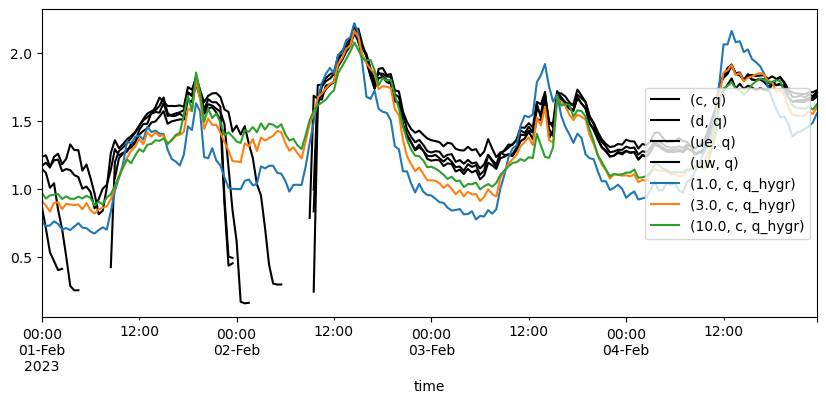

In [36]:


ax = abs_hum_field_df[3].loc['20230201': '20230204'].plot(figsize=(10,4), color='black', legend=False)
(1000*abs_hum_field_hygr_df.loc['20230201': '20230204']).plot(figsize=(10,4), ax=ax)
plt.legend(loc='right')

# 3D Differential Solution

## Calculate interpolated fields (3D)

In [ ]:
HEIGHTS = [3,10]

# gather all measurements into a dataframe, isolate to the heights we care about
df = wind_field_df.join(
    turb_flux_field_df
).join(
    temp_turb_flux_field_df
).join(
    abs_hum_field_df
).join(
    adv_flux_field_df
).join(
    dryair_density_field_df
).join(
    temp_field_df
).join(
    mixing_ratio_field_df
)
data_df = df[HEIGHTS]

# Gather the instrument locations into a dataframe, isolate to heights we care about
instrument_loc_limited_heights = instrument_loc_df[instrument_loc_df.index.get_level_values(0).isin(HEIGHTS)]

# Transform the dataframe of instrument locations into a form that can be merged with the dataframe of measurements
#   transform
xxx = pd.DataFrame(instrument_loc_limited_heights.unstack().unstack()).T
xxx.columns = xxx.columns.swaplevel(0,2)
xxx.columns = xxx.columns.set_names('measurement', level=2)
#   duplicate the sensor locations so we can join (duplicate) x,y,z info into the dataframe of measurements
instrument_loc_limited_heights_repeated = xxx.loc[xxx.index.repeat(len(data_df))]
instrument_loc_limited_heights_repeated.index = data_df.index
instrument_loc_limited_heights_repeated
data_df = data_df.join(instrument_loc_limited_heights_repeated)

# Create a meshgrid for the interpolation and isolate the x,y,z locations of measurements
xx, yy, zz = np.meshgrid(
    np.linspace(instrument_loc_limited_heights.x.min(), instrument_loc_limited_heights.x.max(), HORIZ_GRID_SPACING),
    np.linspace(instrument_loc_limited_heights.y.min(), instrument_loc_limited_heights.y.max(), HORIZ_GRID_SPACING),
    np.linspace(instrument_loc_limited_heights.z.min(), instrument_loc_limited_heights.z.max(), VERT_GRID_SPACING)
)
spacing_x = np.diff(xx[0,:,0]).mean()
spacing_y = np.diff(yy[:,0,0]).mean()
spacing_z = np.diff(zz[0,0,:]).mean()
points = np.transpose(np.vstack((instrument_loc_limited_heights.x, instrument_loc_limited_heights.y, instrument_loc_limited_heights.z)))

# Calculate interpolated fields
    # VECTOR FIELDS
    # wind velocity fields
u_interp = data_df.loc[:, (slice(None),slice(None),['u'])].apply(
    lambda row:  interpolate.griddata(points, row.values, (xx, yy, zz), method='linear'),
    axis=1
)
v_interp = data_df.loc[:, (slice(None),slice(None),['v'])].apply(
    lambda row:  interpolate.griddata(points, row.values, (xx, yy, zz), method='linear'),
    axis=1
)
w_interp = data_df.loc[:, (slice(None),slice(None),['w'])].apply(
    lambda row:  interpolate.griddata(points, row.values, (xx, yy, zz), method='linear'),
    axis=1
)
    # turb. flux fields
u_q__interp = data_df.loc[:, (slice(None),slice(None),['u_h2o_'])].apply(
    lambda row:  interpolate.griddata(points, row.values, (xx, yy, zz), method='linear'),
    axis=1
)
v_q__interp = data_df.loc[:, (slice(None),slice(None),['v_h2o_'])].apply(
    lambda row:  interpolate.griddata(points, row.values, (xx, yy, zz), method='linear'),
    axis=1
)
w_q__interp = data_df.loc[:, (slice(None),slice(None),['w_h2o_'])].apply(
    lambda row:  interpolate.griddata(points, row.values, (xx, yy, zz), method='linear'),
    axis=1
)
    # SCALAR FIELDS
rho_interp = data_df.loc[:, (slice(None),slice(None),['rho'])].apply(
    lambda row:  interpolate.griddata(points, row.values, (xx, yy, zz), method='linear'),
    axis=1
)
r_interp = data_df.loc[:, (slice(None),slice(None),['r'])].apply(
    lambda row:  interpolate.griddata(points, row.values, (xx, yy, zz), method='linear'),
    axis=1
)
q_interp = data_df.loc[:, (slice(None),slice(None),['q'])].apply(
    lambda row:  interpolate.griddata(points, row.values, (xx, yy, zz), method='linear'),
    axis=1
)

### PLOT: Example of a 3d interpolated wind field

In [ ]:

ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
ax.quiver(
    xx[::5,::5,::2], 
    yy[::5,::5,::2],
    zz[::5,::5,::2],
    u_interp[100][::5,::5,::2],
    v_interp[100][::5,::5,::2], 
    w_interp[100][::5,::5,::2],
    label='interpolated'
)
# plt.quiver(
#     data_df.iloc[100][(slice(None),slice(None),'x')].values.astype('float'),
#     data_df.iloc[100][(slice(None),slice(None),'y')].values.astype('float'),
#     data_df.iloc[100][(slice(None),slice(None),'z')].values.astype('float'),
#     data_df.iloc[100][(slice(None),slice(None),'u')].values.astype('float'),
#     data_df.iloc[100][(slice(None),slice(None),'v')].values.astype('float'),
#     data_df.iloc[100][(slice(None),slice(None),'w')].values.astype('float'),
#     label='measured',
#     color='red'
# )

In [ ]:
stable_mean_u_field = np.nanmean(np.stack(u_interp[u_interp.index.isin(ri_stable_times)].values), axis = 0)
stable_mean_v_field = np.nanmean(np.stack(v_interp[v_interp.index.isin(ri_stable_times)].values), axis = 0)
stable_mean_w_field = np.nanmean(np.stack(w_interp[w_interp.index.isin(ri_stable_times)].values), axis = 0)
# 3d plot
ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
ax.quiver(xx[::5,::5,::2],     yy[::5,::5,::2],    zz[::5,::5,::2], stable_mean_u_field[::5,::5,::2], stable_mean_v_field[::5,::5,::2],  stable_mean_w_field[::5,::5,::2],label='interpolated',)

In [ ]:
fig, axes = plt.subplots(3,2, figsize=(5,7.5), sharex=True, sharey=True)
for ax in axes.flatten():
    ax.set_aspect('equal')

stable_mean_u_field = np.nanmean(np.stack(u_interp[u_interp.index.isin(ri_stable_times)].values), axis = 0)
stable_mean_v_field = np.nanmean(np.stack(v_interp[v_interp.index.isin(ri_stable_times)].values), axis = 0)
stable_mean_w_field = np.nanmean(np.stack(w_interp[w_interp.index.isin(ri_stable_times)].values), axis = 0)
axes[0,0].quiver(
    xx[::5,::5,4],  yy[::5,::5,4],
    stable_mean_u_field[::5,::5,4], stable_mean_v_field[::5,::5,4], 
)
axes[0,0].set_title('stable, 4.5m')
axes[0,1].quiver(
    xx[::5,::5,15],  yy[::5,::5,15],
    stable_mean_u_field[::5,::5,15], stable_mean_v_field[::5,::5,15], 
)
axes[0,1].set_title('stable, 8m')

unstable_mean_u_field = np.nanmean(np.stack(u_interp[u_interp.index.isin(ri_unstable_times)].values), axis = 0)
unstable_mean_v_field = np.nanmean(np.stack(v_interp[v_interp.index.isin(ri_unstable_times)].values), axis = 0)
unstable_mean_w_field = np.nanmean(np.stack(w_interp[w_interp.index.isin(ri_unstable_times)].values), axis = 0)
axes[1,0].quiver(
    xx[::5,::5,4],  yy[::5,::5,4],
    unstable_mean_u_field[::5,::5,4], unstable_mean_v_field[::5,::5,4], 
)
axes[1,0].set_title('unstable, 4.5m')
axes[1,1].quiver(
    xx[::5,::5,15],  yy[::5,::5,15],
    unstable_mean_u_field[::5,::5,15], unstable_mean_v_field[::5,::5,15], 
)
axes[1,1].set_title('unstable, 8m')

neutral_mean_u_field = np.nanmean(np.stack(u_interp[u_interp.index.isin(ri_neutral_times)].values), axis = 0)
neutral_mean_v_field = np.nanmean(np.stack(v_interp[v_interp.index.isin(ri_neutral_times)].values), axis = 0)
neutral_mean_w_field = np.nanmean(np.stack(w_interp[w_interp.index.isin(ri_neutral_times)].values), axis = 0)
axes[2,0].quiver(
    xx[::5,::5,4],  yy[::5,::5,4],
    neutral_mean_u_field[::5,::5,4], neutral_mean_v_field[::5,::5,4], 
)
axes[2,0].set_title('neutral, 4.5m')
axes[2,1].quiver(
    xx[::5,::5,15],  yy[::5,::5,15],
    neutral_mean_u_field[::5,::5,15], neutral_mean_v_field[::5,::5,15], 
)
axes[2,1].set_title('neutral, 8m')
plt.tight_layout()

In [ ]:
src_unstable = tidy_df[tidy_df.variable.isin(['w_h2o__3m_c', 'w_h2o__20m_c'])]
src_unstable = src_unstable[(src_unstable.time >= '20221130') & (src_unstable.time < '20230509')]
src_unstable = src_unstable[src_unstable.time.isin(set(ri_unstable_times).intersection(set(nobs_times)))]
src_unstable = src_unstable.pivot_table(index='time', values='value', columns='variable')
src_unstable['diff_unstable'] = src_unstable['w_h2o__20m_c'] - src_unstable['w_h2o__3m_c']

src_stable = tidy_df[tidy_df.variable.isin(['w_h2o__3m_c', 'w_h2o__20m_c'])]
src_stable = src_stable[(src_stable.time >= '20221130') & (src_stable.time < '20230509')]
src_stable = src_stable[src_stable.time.isin(set(ri_stable_times).intersection(set(nobs_times)))]
src_stable = src_stable.pivot_table(index='time', values='value', columns='variable')
src_stable['diff_stable'] = src_stable['w_h2o__20m_c'] - src_stable['w_h2o__3m_c']

src_neutral = tidy_df[tidy_df.variable.isin(['w_h2o__3m_c', 'w_h2o__20m_c'])]
src_neutral = src_neutral[(src_neutral.time >= '20221130') & (src_neutral.time < '20230509')]
src_neutral = src_neutral[src_neutral.time.isin(set(ri_neutral_times).intersection(set(nobs_times)))]
src_neutral = src_neutral.pivot_table(index='time', values='value', columns='variable')
src_neutral['diff_neutral'] = src_neutral['w_h2o__20m_c'] - src_neutral['w_h2o__3m_c']

src = pd.concat([
    src_neutral[['diff_neutral']].reset_index(),
    src_stable[['diff_stable']].reset_index(),
    src_unstable[['diff_unstable']].reset_index(),
])
alt.Chart(
    src.reset_index()
    # src.reset_index()
).transform_fold([
    'diff_neutral', 'diff_stable', 'diff_unstable'
]).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q'),
    alt.Color('key:N')
).properties(width=150, height=150)

In [ ]:
src_unstable = tidy_df[tidy_df.variable.isin(['w_h2o__3m_c', 'w_h2o__20m_c'])]
src_unstable = src_unstable[(src_unstable.time >= '20221130') & (src_unstable.time < '20230509')]
src_unstable = src_unstable[src_unstable.time.isin(set(ri_unstable_times).intersection(set(nobs_times)))]
src_unstable = src_unstable.pivot_table(index='time', values='value', columns='variable')
src_unstable = src_unstable.reset_index()

src_stable = tidy_df[tidy_df.variable.isin(['w_h2o__3m_c', 'w_h2o__20m_c'])]
src_stable = src_stable[(src_stable.time >= '20221130') & (src_stable.time < '20230509')]
src_stable = src_stable[src_stable.time.isin(set(ri_stable_times).intersection(set(nobs_times)))]
src_stable = src_stable.pivot_table(index='time', values='value', columns='variable')
src_stable = src_stable.reset_index()

src_neutral = tidy_df[tidy_df.variable.isin(['w_h2o__3m_c', 'w_h2o__20m_c'])]
src_neutral = src_neutral[(src_neutral.time >= '20221130') & (src_neutral.time < '20230509')]
src_neutral = src_neutral[src_neutral.time.isin(set(ri_neutral_times).intersection(set(nobs_times)))]
src_neutral = src_neutral.pivot_table(index='time', values='value', columns='variable')
src_neutral = src_neutral.reset_index()

chart = alt.Chart(
).transform_fold([
    'w_h2o__3m_c', 'w_h2o__20m_c'
]).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q'),
    alt.Color('key:N')
)

alt.layer(
    chart,
    data =  src_stable[(src_stable.time >= '20221130') & (src_stable.time < '20230509')].reset_index()
) | alt.layer(
    chart,
    data =  src_neutral[(src_neutral.time >= '20221130') & (src_neutral.time < '20230509')].reset_index()
) | alt.layer(
    chart,
    data =  src_unstable[(src_unstable.time >= '20221130') & (src_unstable.time < '20230509')].reset_index()
)



In [ ]:
src_unstable = tidy_df[tidy_df.variable.isin(['w_h2o__3m_c', 'w_h2o__20m_c'])]
src_unstable = src_unstable[src_unstable.time.isin(set(ri_unstable_times).intersection(set(nobs_times)))]
src_unstable = src_unstable.pivot_table(index='time', values='value', columns='variable')
src_unstable['diff_unstable'] = src_unstable['w_h2o__20m_c'] - src_unstable['w_h2o__3m_c']

src_stable = tidy_df[tidy_df.variable.isin(['w_h2o__3m_c', 'w_h2o__20m_c'])]
src_stable = src_stable[src_stable.time.isin(set(ri_stable_times).intersection(set(nobs_times)))]
src_stable = src_stable.pivot_table(index='time', values='value', columns='variable')
src_stable['diff_stable'] = src_stable['w_h2o__20m_c'] - src_stable['w_h2o__3m_c']

src_neutral = tidy_df[tidy_df.variable.isin(['w_h2o__3m_c', 'w_h2o__20m_c'])]
src_neutral = src_neutral[src_neutral.time.isin(set(ri_neutral_times).intersection(set(nobs_times)))]
src_neutral = src_neutral.pivot_table(index='time', values='value', columns='variable')
src_neutral['diff_neutral'] = src_neutral['w_h2o__20m_c'] - src_neutral['w_h2o__3m_c']

src = pd.concat([
    src_neutral[['diff_neutral']].reset_index(),
    src_stable[['diff_stable']].reset_index(),
    src_unstable[['diff_unstable']].reset_index(),
])
alt.Chart(
    src[(src.time >= '20221130') & (src.time < '20230509')].reset_index()
    # src.reset_index()
).transform_fold([
    'diff_neutral', 'diff_stable', 'diff_unstable'
]).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q'),
    alt.Color('key:N')
)

In [ ]:
src = tidy_df.query("measurement == 'wind direction'")
src = src[src.time.isin(ri_unstable_times)]
src
alt.Chart(src).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q'),
    alt.Color('height:O').scale(scheme='turbo'),
    alt.Facet('tower:N')
)

## Calculate terms (3D)

Calculate advective terms in both the Paw U form

$u \rho \dfrac{\partial s}{\partial x} + v \rho \dfrac{\partial s}{\partial y} + w \rho \dfrac{\partial s}{\partial z}$

and in the Sun form

$u \dfrac{\partial q}{\partial x} + v \dfrac{\partial q}{\partial y} + w \dfrac{\partial q}{\partial z}$

and also calculate the turbulent flux divergence terms (same for Paw U and Sun)

$\dfrac{\partial \overline{u'q'}}{\partial x} + \dfrac{\partial \overline{v'q'}}{\partial y} + \dfrac{\partial \overline{w'q'}}{\partial z}$

In [ ]:
# Create dataframe with grids of interpolated data
u_interp.name = 'u'
v_interp.name = 'v'
w_interp.name = 'w'
u_q__interp.name = 'u_q_'
v_q__interp.name = 'v_q_'
w_q__interp.name = 'w_q_'
rho_interp.name = 'rho'
r_interp.name = 'r'
q_interp.name = 'q'

fields_df = pd.DataFrame(u_interp).join(
    v_interp
).join(
    w_interp
).join(
    u_q__interp
).join(
    v_q__interp
).join(
    w_q__interp
).join(
    rho_interp
).join(
    r_interp
).join(
    q_interp
)

In [ ]:
# Iterate over the time series of fields and calculate the terms 
# We take the median of the gridded values.
# The apply function returns a tuple of 4 values, with each tuple contains values 
# for the following in order:
# means of:  lateral_advection_pawu , vertical_advection_pawu ,  lateral_advection_sun , vertical_advection_sun, lateral_turb_flux_div, vertical_turb_flux_div 
# medians of:  lateral_advection_pawu , vertical_advection_pawu ,  lateral_advection_sun , vertical_advection_sun, lateral_turb_flux_div, vertical_turb_flux_div 
advective_terms_3d = fields_df.apply(
    lambda row: 
    (
        # Lateral advection Paw U style
        np.nanmean(
            row['u']*row['rho']*np.gradient(row['r'], spacing_x, axis=0)
            +
            row['v']*row['rho']*np.gradient(row['r'], spacing_y, axis=1)
        ),
        # Vertical advection Paw U style
        np.nanmean(row['w']*row['rho']*np.gradient(row['r'], spacing_z, axis=2)),
        # Lateral advection Sun style
        np.nanmean(
            row['u']*np.gradient(row['q'], spacing_x, axis=0)
            +
            row['v']*np.gradient(row['q'], spacing_y, axis=1)
        ),
        # Vertical advection Sun style
        np.nanmean(row['w']*np.gradient(row['q'], spacing_z, axis=2)),
        # Lateral turb. flux divergence
        np.nanmean(
            np.gradient(row['u_q_'], spacing_x, axis=0)
            +
            np.gradient(row['v_q_'], spacing_y, axis=1)
        ),
        # Vertical turb. flux divergence
        np.nanmean(np.gradient(row['w_q_'], spacing_z, axis=2)),
        # Vertical air density flux term (Paw U only)
        ###???
        # Lateral advection Paw U style
        np.nanmedian(
            row['u']*row['rho']*np.gradient(row['r'], spacing_x, axis=0)
            +
            row['v']*row['rho']*np.gradient(row['r'], spacing_y, axis=1)
        ),
        # Vertical advection Paw U style
        np.nanmedian(row['w']*row['rho']*np.gradient(row['r'], spacing_z, axis=2)),
        # Lateral advection Sun style
        np.nanmedian(
            row['u']*np.gradient(row['q'], spacing_x, axis=0)
            +
            row['v']*np.gradient(row['q'], spacing_y, axis=1)
        ),
        # Vertical advection Sun style
        np.nanmedian(row['w']*np.gradient(row['q'], spacing_z, axis=2)),
        # Lateral turb. flux divergence
        np.nanmedian(
            np.gradient(row['u_q_'], spacing_x, axis=0)
            +
            np.gradient(row['v_q_'], spacing_y, axis=1)
        ),
        # Vertical turb. flux divergence
        np.nanmedian(np.gradient(row['w_q_'], spacing_z, axis=2)),
        # Vertical air density flux term (Paw U only)
        ###???
    )
    ,
    axis = 1
)
advective_terms_3d = pd.DataFrame(
    [[a, b, c, d, e, f, g, h, i, j, k, l] for a,b,c,d,e,f,g,h,i,j,k,l in advective_terms_3d.values], 
    columns=[
        'lateral_advection_pawu (mean)',
        'vertical_advection_pawu (mean)',
        'lateral_advection_sun (mean)',
        'vertical_advection_sun (mean)',
        'lateral_turb_flux_div (mean)',
        'vertical_turb_flux_div (mean)',
        
        'lateral_advection_pawu (median)',
        'vertical_advection_pawu (median)',
        'lateral_advection_sun (median)',
        'vertical_advection_sun (median)',
        'lateral_turb_flux_div (median)',
        'vertical_turb_flux_div (median)',
    ]
)
advective_terms_3d.index = fields_df.index

In [ ]:
advective_terms_3d = advective_terms_3d*7
advective_terms_3d

## Examine results

In [ ]:
mean_chart = (alt.Chart(
    (advective_terms_3d/7).reset_index()
).transform_fold(
    [c for c in list(advective_terms_3d.columns) if 'turb' not in c and 'mean' in c]
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q'),
    alt.Color('key:N')
).properties(width=200, height = 150) | alt.Chart(
    advective_terms_3d.reset_index()
).transform_fold(
    [c for c in list(advective_terms_3d.columns) if 'turb' in c and 'mean' in c]
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q'),
    alt.Color('key:N')
).properties(width=200, height = 150)).resolve_scale(color='independent')

median_chart = (alt.Chart(
    (advective_terms_3d/7).reset_index()
).transform_fold(
    [c for c in list(advective_terms_3d.columns) if 'turb' not in c and 'median' in c]
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q'),
    alt.Color('key:N')
).properties(width=200, height = 150) | alt.Chart(
    advective_terms_3d.reset_index()
).transform_fold(
    [c for c in list(advective_terms_3d.columns) if 'turb' in c and 'median' in c]
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q'),
    alt.Color('key:N')
).properties(width=200, height = 150)).resolve_scale(color='independent')

(mean_chart & median_chart).resolve_scale(y='shared', x='shared')

In [ ]:
alt.Chart(
    advective_terms_3d.loc['20230201': '20230205'].reset_index()
).transform_fold(
    list(advective_terms_3d.columns)
).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q'),
    # .scale(domain=[0,0.02], clamp=True),
    alt.Color('key:N')
)

# 2D Differential Solution

## 3m height

Repeat all the steps we did above, but just for a single plane at 3m

In [ ]:
HEIGHTS_2D = [3]

# gather all measurements into a dataframe, isolate to the heights we care about
df = wind_field_df.join(
    turb_flux_field_df
).join(
    temp_turb_flux_field_df
).join(
    abs_hum_field_df
).join(
    adv_flux_field_df
).join(
    dryair_density_field_df
).join(
    temp_field_df
).join(
    mixing_ratio_field_df
)
data_df_2d = df[HEIGHTS_2D]

# Gather the instrument locations into a dataframe, isolate to heights we care about
instrument_loc_limited_heights_2d = instrument_loc_df[instrument_loc_df.index.get_level_values(0).isin(HEIGHTS_2D)]

# Transform the dataframe of instrument locations into a form that can be merged with the dataframe of measurements
#   transform
xxx = pd.DataFrame(instrument_loc_limited_heights_2d.unstack().unstack()).T
xxx.columns = xxx.columns.swaplevel(0,2)
xxx.columns = xxx.columns.set_names('measurement', level=2)
#   duplicate the sensor locations so we can join (duplicate) x,y,z info into the dataframe of measurements
instrument_loc_limited_heights_2d_repeated = xxx.loc[xxx.index.repeat(len(data_df_2d))]
instrument_loc_limited_heights_2d_repeated.index = data_df_2d.index
instrument_loc_limited_heights_2d_repeated
data_df_2d = data_df_2d.join(instrument_loc_limited_heights_2d_repeated)
data_df_2d

# Create a meshgrid for the interpolation and isolate the x,y,z locations of measurements
xx_2d, yy_2d = np.meshgrid(
    np.linspace(instrument_loc_limited_heights_2d.x.min(), instrument_loc_limited_heights_2d.x.max(), HORIZ_GRID_SPACING),
    np.linspace(instrument_loc_limited_heights_2d.y.min(), instrument_loc_limited_heights_2d.y.max(), HORIZ_GRID_SPACING)
)
spacing_x_2d = np.diff(xx_2d[0,:]).mean()
spacing_y_2d = np.diff(yy_2d[:,0]).mean()
points_2d = np.transpose(np.vstack((instrument_loc_limited_heights_2d.x, instrument_loc_limited_heights_2d.y)))

# Calculate interpolated fields
    # VECTOR FIELDS
    # wind velocity fields
u_interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['u'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)
v_interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['v'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)
w_interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['w'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)
    # turb. flux fields
u_q__interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['u_h2o_'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)
v_q__interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['v_h2o_'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)
w_q__interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['w_h2o_'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)
    # SCALAR FIELDS
rho_interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['rho'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)
r_interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['r'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)
q_interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['q'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)

# Create dataframe with grids of interpolated data
u_interp_2d.name = 'u'
v_interp_2d.name = 'v'
w_interp_2d.name = 'w'
u_q__interp_2d.name = 'u_q_'
v_q__interp_2d.name = 'v_q_'
w_q__interp_2d.name = 'w_q_'
rho_interp_2d.name = 'rho'
r_interp_2d.name = 'r'
q_interp_2d.name = 'q'

fields_df_2d = pd.DataFrame(u_interp_2d).join(
    v_interp_2d
).join(
    w_interp_2d
).join(
    u_q__interp_2d
).join(
    v_q__interp_2d
).join(
    w_q__interp_2d
).join(
    rho_interp_2d
).join(
    r_interp_2d
).join(
    q_interp_2d
)

# Iterate over the time series of fields and calculate the terms 
# We take the median of the gridded values.
# The apply function returns a tuple of 4 values, with each tuple contains values 
# for the following in order:
#  means of: lateral_advection_pawu , vertical_advection_pawu ,  lateral_advection_sun , vertical_advection_sun, lateral_turb_flux_div, vertical_turb_flux_div 
#  medians of: lateral_advection_pawu , vertical_advection_pawu ,  lateral_advection_sun , vertical_advection_sun, lateral_turb_flux_div, vertical_turb_flux_div 
advective_terms_2d_3m = fields_df_2d.apply(
    lambda row: 
    (
        # Lateral advection Paw U style
        np.nanmean(
            row['u']*row['rho']*np.gradient(row['r'], spacing_x_2d, axis=0)
            +
            row['v']*row['rho']*np.gradient(row['r'], spacing_y_2d, axis=1)
        ),
        # Lateral advection Sun style
        np.nanmean(
            row['u']*np.gradient(row['q'], spacing_x_2d, axis=0)
            +
            row['v']*np.gradient(row['q'], spacing_y_2d, axis=1)
        ),
        # Lateral turb. flux divergence
        np.nanmean(
            np.gradient(row['u_q_'], spacing_x_2d, axis=0)
            +
            np.gradient(row['v_q_'], spacing_y_2d, axis=1)
        ),
        # Lateral advection Paw U style
        np.nanmedian(
            row['u']*row['rho']*np.gradient(row['r'], spacing_x_2d, axis=0)
            +
            row['v']*row['rho']*np.gradient(row['r'], spacing_y_2d, axis=1)
        ),
        # Lateral advection Sun style
        np.nanmedian(
            row['u']*np.gradient(row['q'], spacing_x_2d, axis=0)
            +
            row['v']*np.gradient(row['q'], spacing_y_2d, axis=1)
        ),
        # Lateral turb. flux divergence
        np.nanmedian(
            np.gradient(row['u_q_'], spacing_x_2d, axis=0)
            +
            np.gradient(row['v_q_'], spacing_y_2d, axis=1)
        ),
    ),
    axis = 1
)
advective_terms_2d_3m = pd.DataFrame(
    [[a, b, c, d, e, f] for a, b, c, d, e, f in advective_terms_2d_3m.values], 
    columns=[
        'lateral_advection_pawu (mean)', 
        'lateral_advection_sun (mean)',
        'lateral_turb_flux_div (mean)', 
        'lateral_advection_pawu (median)', 
        'lateral_advection_sun (median)',
        'lateral_turb_flux_div (median)', 
    ]
)
advective_terms_2d_3m.index = fields_df_2d.index

### PLOT: Example of a 2d interpolated wind field

In [ ]:

plt.quiver(
    xx_2d[::4], 
    yy_2d[::4],
    u_interp_2d[100][::4],
    v_interp_2d[100][::4], 
    label='interpolated'
)
plt.quiver(
    data_df_2d.iloc[100][(slice(None),slice(None),'x')].values.astype('float'),
    data_df_2d.iloc[100][(slice(None),slice(None),'y')].values.astype('float'),
    data_df_2d.iloc[100][(slice(None),slice(None),'u')].values.astype('float'),
    data_df_2d.iloc[100][(slice(None),slice(None),'v')].values.astype('float'),
    label='measured',
    color='red'
)

## 10m height

Repeat all the steps we did above, but just for a single plane at 3m

In [ ]:
HEIGHTS_2D = [10]

# gather all measurements into a dataframe, isolate to the heights we care about
df = wind_field_df.join(
    turb_flux_field_df
).join(
    temp_turb_flux_field_df
).join(
    abs_hum_field_df
).join(
    adv_flux_field_df
).join(
    dryair_density_field_df
).join(
    temp_field_df
).join(
    mixing_ratio_field_df
)
data_df_2d = df[HEIGHTS_2D]

# Gather the instrument locations into a dataframe, isolate to heights we care about
instrument_loc_limited_heights_2d = instrument_loc_df[instrument_loc_df.index.get_level_values(0).isin(HEIGHTS_2D)]

# Transform the dataframe of instrument locations into a form that can be merged with the dataframe of measurements
#   transform
xxx = pd.DataFrame(instrument_loc_limited_heights_2d.unstack().unstack()).T
xxx.columns = xxx.columns.swaplevel(0,2)
xxx.columns = xxx.columns.set_names('measurement', level=2)
#   duplicate the sensor locations so we can join (duplicate) x,y,z info into the dataframe of measurements
instrument_loc_limited_heights_2d_repeated = xxx.loc[xxx.index.repeat(len(data_df_2d))]
instrument_loc_limited_heights_2d_repeated.index = data_df_2d.index
instrument_loc_limited_heights_2d_repeated
data_df_2d = data_df_2d.join(instrument_loc_limited_heights_2d_repeated)
data_df_2d

# Create a meshgrid for the interpolation and isolate the x,y,z locations of measurements
xx_2d, yy_2d = np.meshgrid(
    np.linspace(instrument_loc_limited_heights_2d.x.min(), instrument_loc_limited_heights_2d.x.max(), HORIZ_GRID_SPACING),
    np.linspace(instrument_loc_limited_heights_2d.y.min(), instrument_loc_limited_heights_2d.y.max(), HORIZ_GRID_SPACING)
)
spacing_x_2d = np.diff(xx_2d[0,:]).mean()
spacing_y_2d = np.diff(yy_2d[:,0]).mean()
points_2d = np.transpose(np.vstack((instrument_loc_limited_heights_2d.x, instrument_loc_limited_heights_2d.y)))

# Calculate interpolated fields
    # VECTOR FIELDS
    # wind velocity fields
u_interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['u'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)
v_interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['v'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)
w_interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['w'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)
    # turb. flux fields
u_q__interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['u_h2o_'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)
v_q__interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['v_h2o_'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)
w_q__interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['w_h2o_'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)
    # SCALAR FIELDS
rho_interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['rho'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)
r_interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['r'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)
q_interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['q'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)

# Create dataframe with grids of interpolated data
u_interp_2d.name = 'u'
v_interp_2d.name = 'v'
w_interp_2d.name = 'w'
u_q__interp_2d.name = 'u_q_'
v_q__interp_2d.name = 'v_q_'
w_q__interp_2d.name = 'w_q_'
rho_interp_2d.name = 'rho'
r_interp_2d.name = 'r'
q_interp_2d.name = 'q'

fields_df_2d = pd.DataFrame(u_interp_2d).join(
    v_interp_2d
).join(
    w_interp_2d
).join(
    u_q__interp_2d
).join(
    v_q__interp_2d
).join(
    w_q__interp_2d
).join(
    rho_interp_2d
).join(
    r_interp_2d
).join(
    q_interp_2d
)

# Iterate over the time series of fields and calculate the terms 
# We take the median of the gridded values.
# The apply function returns a tuple of 4 values, with each tuple contains values 
# for the following in order:
#  lateral_advection_pawu , vertical_advection_pawu ,  lateral_advection_sun , vertical_advection_sun, lateral_turb_flux_div, vertical_turb_flux_div 
advective_terms_2d_10m = fields_df_2d.apply(
    lambda row: 
    (
        # Lateral advection Paw U style
        np.nanmean(
            row['u']*row['rho']*np.gradient(row['r'], spacing_x_2d, axis=0)
            +
            row['v']*row['rho']*np.gradient(row['r'], spacing_y_2d, axis=1)
        ),
        # Lateral advection Sun style
        np.nanmean(
            row['u']*np.gradient(row['q'], spacing_x_2d, axis=0)
            +
            row['v']*np.gradient(row['q'], spacing_y_2d, axis=1)
        ),
        # Lateral turb. flux divergence
        np.nanmean(
            np.gradient(row['u_q_'], spacing_x_2d, axis=0)
            +
            np.gradient(row['v_q_'], spacing_y_2d, axis=1)
        ),
        # Lateral advection Paw U style
        np.nanmedian(
            row['u']*row['rho']*np.gradient(row['r'], spacing_x_2d, axis=0)
            +
            row['v']*row['rho']*np.gradient(row['r'], spacing_y_2d, axis=1)
        ),
        # Lateral advection Sun style
        np.nanmedian(
            row['u']*np.gradient(row['q'], spacing_x_2d, axis=0)
            +
            row['v']*np.gradient(row['q'], spacing_y_2d, axis=1)
        ),
        # Lateral turb. flux divergence
        np.nanmedian(
            np.gradient(row['u_q_'], spacing_x_2d, axis=0)
            +
            np.gradient(row['v_q_'], spacing_y_2d, axis=1)
        ),
    ),
    axis = 1
)
advective_terms_2d_10m = pd.DataFrame(
    [[a, b, c, d, e, f] for a, b, c, d, e, f in advective_terms_2d_10m.values], 
    columns=[
        'lateral_advection_pawu (mean)', 
        'lateral_advection_sun (mean)',
        'lateral_turb_flux_div (mean)', 
        'lateral_advection_pawu (median)', 
        'lateral_advection_sun (median)',
        'lateral_turb_flux_div (median)', 
    ]
)
advective_terms_2d_10m.index = fields_df_2d.index

## Average the two planes

In [ ]:
advective_terms_2d_3m

In [ ]:
advective_terms_2d_10m

In [ ]:
advective_terms_2d = (advective_terms_2d_3m + advective_terms_2d_10m)/2
advective_terms_2d = advective_terms_2d*7

## Examine results

In [ ]:
alt.Chart(
    advective_terms_2d.reset_index()
).transform_fold(
    [c for c in list(advective_terms_2d.columns) if 'turb' not in c]
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q'),
    alt.Color('key:N')
).properties(width=200, height = 150) | alt.Chart(
    advective_terms_2d.reset_index()
).transform_fold(
    [c for c in list(advective_terms_2d.columns) if 'turb' in c]
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q'),
    alt.Color('key:N')
).properties(width=200, height = 150)

In [ ]:
alt.Chart(
    advective_terms_3d.reset_index()
).transform_fold(
    [c for c in list(advective_terms_3d.columns) if 'turb' not in c]
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q'),
    alt.Color('key:N')
).properties(width=200, height = 150) | alt.Chart(
    advective_terms_3d.reset_index()
).transform_fold(
    [c for c in list(advective_terms_3d.columns) if 'turb' in c]
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q'),
    alt.Color('key:N')
).properties(width=200, height = 150)

# Surface Integral Solution

## Define area of triangular prism faces

In [ ]:
from metpy.units import units

In [ ]:
# Define face areas
A1 = A2 = A3 = 37 * 7 * units('m^2')
A4 = A5 = 580.2 * units('m^2')
CV_HEIGHT = 7*units('m')
VOLUME = A4*CV_HEIGHT
A1, A2, A3, A4, A5, VOLUME

## Define normal vectors to the triangular prism faces

In [ ]:
# ELI'S angles
n1 = np.array([ np.cos(np.deg2rad(258.7)),   np.sin(np.deg2rad(258.7))])*units(None)
n2 = np.array([ np.cos(np.deg2rad(20.1)),   np.sin(np.deg2rad(20.1))])*units(None)
n3 = np.array([ np.cos(np.deg2rad(139.26)),   np.sin(np.deg2rad(139.26))])*units(None)

# DANNY'S angles
# n1 = np.array([ np.cos(np.deg2rad(269.5)),   np.sin(np.deg2rad(269.5))])*units(None)
# n2 = np.array([ np.cos(np.deg2rad(19.5)),   np.sin(np.deg2rad(19.5))])*units(None)
# n3 = np.array([ np.cos(np.deg2rad(143.5)),   np.sin(np.deg2rad(143.5))])*units(None)

In [ ]:
import geopandas as gpd
instrument_loc_df = gpd.GeoDataFrame(
    instrument_loc_df,
    geometry = gpd.points_from_xy(
        instrument_loc_df.x, 
        instrument_loc_df.y, 
        instrument_loc_df.z
    ),
    crs = 'EPSG:32613'
)
instrument_loc_df = instrument_loc_df.to_crs('EPSG:4326')
instrument_loc_df

## Calculate storage term

In [ ]:
storage_change_term = tidy_df[
    tidy_df.measurement.isin(['specific humidity', 'air density'])
].query("tower == 'c'").query("height <= 10").query("height >= 3").groupby(
    ['time', 'tower', 'measurement']
)[['value']].mean().reset_index() 
storage_change_term = storage_change_term.pivot_table(index='time', values='value', columns='measurement')

In [ ]:
timestep = storage_change_term.index.diff()[1].seconds * units('seconds')
print(timestep)
absolute_humidity = storage_change_term['specific humidity'].values * units("g/g")  * (
    storage_change_term['air density'].values * units("kg/m^3")
)
delta_humidity = np.diff(absolute_humidity * VOLUME, prepend=np.nan)
dq_dt = delta_humidity / timestep

In [ ]:
storage_change_term['absolute humidity (g/m^3)'] = absolute_humidity.to('g/m^3')
storage_change_term['delta water storage (g/s)'] = dq_dt.to('grams/second')

## Calculate advective flux

In [ ]:
advective_flux_3m_ue = wind_field_df[3]['ue'].multiply(
    abs_hum_field_df[3]['ue']['q'],
    axis=0
).rename(columns={'u': 'uq', 'v': 'vq','w': 'wq',})

advective_flux_10m_ue = wind_field_df[10]['ue'].multiply(
    abs_hum_field_df[10]['ue']['q'],
    axis=0
).rename(columns={'u': 'uq', 'v': 'vq','w': 'wq',})

advective_flux_3m_uw = wind_field_df[3]['uw'].multiply(
    abs_hum_field_df[3]['uw']['q'],
    axis=0
).rename(columns={'u': 'uq', 'v': 'vq','w': 'wq',})

advective_flux_10m_uw = wind_field_df[10]['uw'].multiply(
    abs_hum_field_df[10]['uw']['q'],
    axis=0
).rename(columns={'u': 'uq', 'v': 'vq','w': 'wq',})

advective_flux_3m_d = wind_field_df[3]['d'].multiply(
    abs_hum_field_df[3]['d']['q'],
    axis=0
).rename(columns={'u': 'uq', 'v': 'vq','w': 'wq',})

advective_flux_10m_d = wind_field_df[10]['d'].multiply(
    abs_hum_field_df[10]['d']['q'],
    axis=0
).rename(columns={'u': 'uq', 'v': 'vq','w': 'wq',})

advective_flux_3m_c = wind_field_df[3]['c'].multiply(
    abs_hum_field_df[3]['c']['q'],
    axis=0
).rename(columns={'u': 'uq', 'v': 'vq','w': 'wq',})

advective_flux_10m_c = wind_field_df[10]['c'].multiply(
    abs_hum_field_df[10]['c']['q'],
    axis=0
).rename(columns={'u': 'uq', 'v': 'vq','w': 'wq',})

In [ ]:
# Calculate the average u, v, and w components needed to calculate flux through each face
face1_avg_u_flux = 0.25*(
    advective_flux_3m_uw['uq'] + advective_flux_10m_uw['uq'] + 
    advective_flux_3m_d['uq'] + advective_flux_10m_d['uq']
)

face1_avg_v_flux = 0.25*(
    advective_flux_3m_uw['vq'] + advective_flux_10m_uw['vq'] + 
    advective_flux_3m_d['vq'] + advective_flux_10m_d['vq']
)

face2_avg_u_flux = 0.25*(
    advective_flux_3m_ue['uq'] + advective_flux_10m_ue['uq'] + 
    advective_flux_3m_d['uq'] + advective_flux_10m_d['uq']
)

face2_avg_v_flux = 0.25*(
    advective_flux_3m_ue['vq'] + advective_flux_10m_ue['vq'] + 
    advective_flux_3m_d['vq'] + advective_flux_10m_d['vq']
)

face3_avg_u_flux = 0.25*(
    advective_flux_3m_ue['uq'] + advective_flux_10m_ue['uq'] + 
    advective_flux_3m_uw['uq'] + advective_flux_10m_uw['uq']
)

face3_avg_v_flux = 0.25*(
    advective_flux_3m_ue['vq'] + advective_flux_10m_ue['vq'] + 
    advective_flux_3m_uw['vq'] + advective_flux_10m_uw['vq']
)

face4_avg_w_flux = 0.25*(
    advective_flux_10m_ue['wq'] + advective_flux_10m_uw['wq'] + 
    advective_flux_10m_c['wq'] + advective_flux_10m_d['wq']
)

face5_avg_w_flux = - 0.25*(
    advective_flux_3m_ue['wq'] + advective_flux_3m_uw['wq'] + 
    advective_flux_3m_c['wq'] + advective_flux_3m_d['wq']
)

# Combine the (separate) u and v components into a list of vectors for the lateral faces
face1_avg_adv_flux = np.array([
    face1_avg_u_flux,
    face1_avg_v_flux
]).T

face2_avg_adv_flux = np.array([
    face2_avg_u_flux,
    face2_avg_v_flux
]).T

face3_avg_adv_flux = np.array([
    face3_avg_u_flux,
    face3_avg_v_flux
]).T

# Project the lateral flux vectors onto the face-normal vectors
face1_projected_adv_flux = np.dot(face1_avg_adv_flux, n1.m)
face2_projected_adv_flux = np.dot(face2_avg_adv_flux, n2.m)
face3_projected_adv_flux = np.dot(face3_avg_adv_flux, n3.m)

# Calculate total lateral and vertical flux
total_lateral_adv_divergence = (
    face1_projected_adv_flux*A1.m + 
    face2_projected_adv_flux*A2.m + 
    face3_projected_adv_flux*A3.m
) / VOLUME.m

total_vertical_adv_divergence = (face4_avg_w_flux*A4 + face5_avg_w_flux*A5)  / VOLUME

## Calculate turbulent flux divergence

In [ ]:
# Calculate the average u, v, and w components needed to calculate flux through each face
face1_avg_u_turb_flux = 0.25*(
    turb_flux_field_df[3]['uw']['u_h2o_'] + turb_flux_field_df[10]['uw']['u_h2o_'] + 
    turb_flux_field_df[3]['d']['u_h2o_'] + turb_flux_field_df[10]['d']['u_h2o_']
)

face1_avg_v_turb_flux = 0.25*(
    turb_flux_field_df[3]['uw']['v_h2o_'] + turb_flux_field_df[10]['uw']['v_h2o_'] + 
    turb_flux_field_df[3]['d']['v_h2o_'] + turb_flux_field_df[10]['d']['v_h2o_']
)

face2_avg_u_turb_flux = 0.25*(
    turb_flux_field_df[3]['ue']['u_h2o_'] + turb_flux_field_df[10]['ue']['u_h2o_'] + 
    turb_flux_field_df[3]['d']['u_h2o_'] + turb_flux_field_df[10]['d']['u_h2o_']
)

face2_avg_v_turb_flux = 0.25*(
    turb_flux_field_df[3]['ue']['v_h2o_'] + turb_flux_field_df[10]['ue']['v_h2o_'] + 
    turb_flux_field_df[3]['d']['v_h2o_'] + turb_flux_field_df[10]['d']['v_h2o_']
)

face3_avg_u_turb_flux = 0.25*(
    turb_flux_field_df[3]['ue']['u_h2o_'] + turb_flux_field_df[10]['ue']['u_h2o_'] + 
    turb_flux_field_df[3]['uw']['u_h2o_'] + turb_flux_field_df[10]['uw']['u_h2o_']
)

face3_avg_v_turb_flux = 0.25*(
    turb_flux_field_df[3]['ue']['v_h2o_'] + turb_flux_field_df[10]['ue']['v_h2o_'] + 
    turb_flux_field_df[3]['uw']['v_h2o_'] + turb_flux_field_df[10]['uw']['v_h2o_']
)

face4_avg_w_turb_flux = 0.25*(
    turb_flux_field_df[10]['ue']['w_h2o_'] + turb_flux_field_df[10]['uw']['w_h2o_'] + 
    turb_flux_field_df[10]['c']['w_h2o_'] + turb_flux_field_df[10]['d']['w_h2o_']
)

face5_avg_w_turb_flux = - 0.25*(
    turb_flux_field_df[3]['ue']['w_h2o_'] + turb_flux_field_df[3]['uw']['w_h2o_'] + 
    turb_flux_field_df[3]['c']['w_h2o_'] + turb_flux_field_df[3]['d']['w_h2o_']
)

# Combine the (separate) u and v components into a list of vectors for the lateral faces
face1_avg_adv_flux = np.array([
    face1_avg_u_turb_flux,
    face1_avg_v_turb_flux
]).T

face2_avg_adv_flux = np.array([
    face2_avg_u_turb_flux,
    face2_avg_v_turb_flux
]).T

face3_avg_adv_flux = np.array([
    face3_avg_u_turb_flux,
    face3_avg_v_turb_flux
]).T

# Project the lateral flux vectors onto the face-normal vectors
face1_projected_turb_flux = np.dot(face1_avg_adv_flux, n1.m)
face2_projected_turb_flux = np.dot(face2_avg_adv_flux, n2.m)
face3_projected_turb_flux = np.dot(face3_avg_adv_flux, n3.m)

# Calculate total lateral and vertical flux
total_lateral_turb_divergence = (
    face1_projected_turb_flux*A1.m + 
    face2_projected_turb_flux*A2.m + 
    face3_projected_turb_flux*A3.m
) / VOLUME.m

total_vertical_turb_divergence = (face4_avg_w_turb_flux*A4 + face5_avg_w_turb_flux*A5)  / VOLUME

## Examine results

In [ ]:
((
    alt.Chart(
        pd.DataFrame(total_vertical_turb_divergence).reset_index()
    ).mark_line().encode(
        alt.X('hoursminutes(time):T'),
        alt.Y('median(w_h2o_):Q')
    )
).properties(title='Vertical Turb. Flux Divergence') | (
    alt.Chart(
        pd.DataFrame(total_lateral_turb_divergence).reset_index().assign(time=total_vertical_turb_divergence.index).rename(columns={0:'u_q_'})
    ).mark_line().encode(
        alt.X('hoursminutes(time):T'),
        alt.Y('median(u_q_):Q')
    )
).properties(title='Lateral Turb. Flux Divergence')).resolve_scale(y='shared', x='shared')

In [ ]:
((
    alt.Chart(
        pd.DataFrame(total_vertical_adv_divergence).reset_index()
    ).mark_line().encode(
        alt.X('hoursminutes(time):T'),
        alt.Y('mean(wq):Q')
    )
    +
    alt.Chart(
        pd.DataFrame(total_vertical_adv_divergence).reset_index()
    ).mark_line(color='red').encode(
        alt.X('hoursminutes(time):T'),
        alt.Y('median(wq):Q')
    )
).properties(title='Vertical Advection') | (
    alt.Chart(
        pd.DataFrame(total_lateral_adv_divergence).reset_index().assign(time=total_vertical_adv_divergence.index).rename(columns={0:'uq'})
    ).mark_line().encode(
        alt.X('hoursminutes(time):T'),
        alt.Y('mean(uq):Q')
    )
    +
    alt.Chart(
        pd.DataFrame(total_lateral_adv_divergence).reset_index().assign(time=total_vertical_adv_divergence.index).rename(columns={0:'uq'})
    ).mark_line(color='red').encode(
        alt.X('hoursminutes(time):T'),
        alt.Y('median(uq):Q')
    )
).properties(title='Lateral Advection')).resolve_scale(y='shared', x='shared')

# 1D Differential Solution

## Calculate horizontal advection (using two-point solution to derivative)

### Using KPS and Annex Hygrometer measurements

In [37]:
# Calculate horizontal advection 
# combine mixing ratio measurements from the two sites into one dataframe 
kpsannex_mixingratio_measurements = mixingratio_ds.sortby('time').sel(
    time=slice(data_start_date, data_cutoff_date)
).resample(time='30min').mean().rename('annex').to_dataframe() / 1000
kps_mixingratio_measurements = abs_hum_field_hygr_df[3]['c']['q_hygr'].rename('kps')
kps_lateral_simple_df = kpsannex_mixingratio_measurements.join(kps_mixingratio_measurements)

# isolate measurements to when wind is up (100˚ - 140˚) or downvalley (300 - 340)
kps_lateral_simple_df = kps_lateral_simple_df.join(
    tidy_df.query("variable == 'dir_10m_c'").set_index('time')['value'].rename('dir_10m_c')
).join(
    tidy_df.query("variable == 'spd_3m_c'").set_index('time')['value'].rename('spd_3m_c')
).join(
    1000*tidy_df.query("variable == 'dryairdensity_3m_c'").set_index('time')['value'].rename('rho')
).join(
    tidy_df.query("variable == 'w_h2o__3m_c'").set_index('time')['value'].rename('w_h2o__3m_c')
)

kps_lateral_simple_df = kps_lateral_simple_df[
    ((kps_lateral_simple_df.dir_10m_c >= 112) & (kps_lateral_simple_df.dir_10m_c <= 152))
    |
    ((kps_lateral_simple_df.dir_10m_c >= 292) & (kps_lateral_simple_df.dir_10m_c <= 332))
]
# label each timestamp up or downvalley
kps_lateral_simple_df['direction'] = kps_lateral_simple_df['dir_10m_c'].apply(lambda x: 'down' if 292 <= x <= 332 else 'up')
# # Calculate deltas. During downvalley winds, ds = annex - kps. During up valley winds, ds = kps - annex
kps_lateral_simple_df['ds'] = kps_lateral_simple_df.apply(
    lambda row: row['annex'] - row['kps'] if row['direction'] == 'down' else row['kps'] - row['annex'],
    axis=1
)
kps_lateral_simple_df['dx'] = 400
kps_lateral_simple_df['ds/dx'] = kps_lateral_simple_df['ds'] / kps_lateral_simple_df['dx']
kps_lateral_simple_df['lateral_advection'] = kps_lateral_simple_df['spd_3m_c'] * kps_lateral_simple_df['rho'] * kps_lateral_simple_df['ds/dx']
from metpy.units import units

kps_lateral_simple_df['ds/dt'] = kps_lateral_simple_df['rho'] * kps_lateral_simple_df['kps'].diff() * units('g/g') / (30*60*units('seconds'))
kps_lateral_simple_df

,annex,kps,dir_10m_c,spd_3m_c,rho,w_h2o__3m_c,direction,ds,dx,ds/dx,lateral_advection,ds/dt
time,,,,,,,,,,,,
2022-11-30 00:00:00,0.000822,0.000801,314.911682,2.926596,991.887331,-0.000318,down,0.000021,400,5.251018e-08,0.000152,NaN
2022-11-30 01:00:00,0.000829,0.000843,304.011566,1.479668,988.873661,-0.000417,down,-0.000014,400,-3.555800e-08,-0.000052,0.000023
2022-11-30 01:30:00,0.000833,0.000836,313.277832,2.253744,989.953995,-0.000101,down,-0.000003,400,-7.632066e-09,-0.000017,-0.000004
2022-11-30 02:30:00,0.000855,0.000864,313.813416,1.378487,988.775849,-0.000268,down,-0.000009,400,-2.206775e-08,-0.000030,0.000015
2022-11-30 03:00:00,0.000852,0.000853,323.678955,1.971775,989.779830,-0.000312,down,-0.000001,400,-3.079558e-09,-0.000006,-0.000006
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-08 21:00:00,0.004023,0.004004,305.594971,2.624317,911.107838,0.001913,down,0.000019,400,4.842059e-08,0.000116,0.000010
2023-05-08 21:30:00,0.003105,0.003312,292.323517,3.195095,896.669090,0.014267,down,-0.000208,400,-5.192192e-07,-0.001488,-0.000344
2023-05-08 22:00:00,0.003082,0.003246,304.695007,1.715134,897.454560,0.001228,down,-0.000165,400,-4.119808e-07,-0.000634,-0.000033


### Using KPS Irga measurements

In [38]:
# get mixing ratio measurements from the corner towers
upwind_s = 0.5*(mixing_ratio_field_df[3, 'ue', 'r'] + mixing_ratio_field_df[3, 'uw', 'r'])
upwind_s.name = 'upwind_s'
kps_lateral_simple_irga_df = pd.DataFrame(upwind_s)
kps_lateral_simple_irga_df['downwind_s'] = mixing_ratio_field_df[3, 'd', 'r']


# # Add wind dir variable
kps_lateral_simple_irga_df = kps_lateral_simple_irga_df.join(
    tidy_df.query("variable == 'dir_10m_c'").set_index('time').loc['20221101': '20230620']['value'].rename('dir_10m_c')
).join(
    tidy_df.query("variable == 'spd_3m_c'").set_index('time').loc['20221101': '20230620']['value'].rename('spd_3m_c')
).join(
    1000*tidy_df.query("variable == 'dryairdensity_3m_c'").set_index('time').loc['20221101': '20230620']['value'].rename('rho')
).join(
    tidy_df.query("variable == 'w_h2o__3m_c'").set_index('time').loc['20221101': '20230620']['value'].rename('w_h2o__3m_c')
)


# isolate measurements to when wind is up (100˚ - 140˚) or downvalley (300 - 340)
kps_lateral_simple_irga_df = kps_lateral_simple_irga_df[
    ((kps_lateral_simple_irga_df.dir_10m_c >= 100) & (kps_lateral_simple_irga_df.dir_10m_c <= 140))
    |
    ((kps_lateral_simple_irga_df.dir_10m_c >= 300) & (kps_lateral_simple_irga_df.dir_10m_c <= 340))
]

# label each timestamp up or downvalley
kps_lateral_simple_irga_df['direction'] = kps_lateral_simple_irga_df['dir_10m_c'].apply(lambda x: 'down' if 300 <= x <= 340 else 'up')
# # Calculate deltas. During downvalley winds, ds = annex - kps. During up valley winds, ds = kps - annex
kps_lateral_simple_irga_df['ds'] = kps_lateral_simple_irga_df.apply(
    lambda row: row['downwind_s'] - row['upwind_s'] if row['direction'] == 'down' else row['upwind_s'] - row['downwind_s'],
    axis=1
)

kps_lateral_simple_irga_df['dx'] = 32
kps_lateral_simple_irga_df['ds/dx'] = kps_lateral_simple_irga_df['ds'] / kps_lateral_simple_irga_df['dx']

kps_lateral_simple_irga_df

kps_lateral_simple_irga_df['lateral_advection_irga'] = kps_lateral_simple_irga_df['spd_3m_c'] * kps_lateral_simple_irga_df['rho'] * kps_lateral_simple_irga_df['ds/dx']
kps_lateral_simple_irga_df

,upwind_s,downwind_s,dir_10m_c,spd_3m_c,rho,w_h2o__3m_c,direction,ds,dx,ds/dx,lateral_advection_irga
time,,,,,,,,,,,
2022-11-30 00:00:00,0.000837,0.000760,314.911682,2.926596,991.887331,-0.000318,down,-0.000077,32,-2.395342e-06,-0.006953
2022-11-30 01:00:00,0.000887,0.000795,304.011566,1.479668,988.873661,-0.000417,down,-0.000091,32,-2.857701e-06,-0.004181
2022-11-30 01:30:00,0.000875,0.000804,313.277832,2.253744,989.953995,-0.000101,down,-0.000071,32,-2.224524e-06,-0.004963
2022-11-30 02:30:00,0.000743,0.000610,313.813416,1.378487,988.775849,-0.000268,down,-0.000133,32,-4.169366e-06,-0.005683
2022-11-30 03:00:00,0.000734,0.000624,323.678955,1.971775,989.779830,-0.000312,down,-0.000110,32,-3.442372e-06,-0.006718
...,...,...,...,...,...,...,...,...,...,...,...
2023-05-08 20:30:00,0.003985,0.003948,309.916077,2.435265,907.155573,0.001586,down,-0.000038,32,-1.172730e-06,-0.002591
2023-05-08 21:00:00,0.003960,0.003918,305.594971,2.624317,911.107838,0.001913,down,-0.000042,32,-1.308562e-06,-0.003129
2023-05-08 22:00:00,0.003301,0.003266,304.695007,1.715134,897.454560,0.001228,down,-0.000034,32,-1.073974e-06,-0.001653


## Calculate vertical advection

### Simple two-point solution to the derivative

#### 3 to 10m

In [39]:
kps_mixingratio_measurements_3m = tidy_df.query("variable == 'mixingratio_3m_c'").set_index('time')['value'].rename('mixingratio_3m_c')
kps_mixingratio_measurements_10m = tidy_df.query("variable == 'mixingratio_10m_c'").set_index('time')['value'].rename('mixingratio_10m_c')
kps_vert_simple_df_3to10 = pd.DataFrame(kps_mixingratio_measurements_3m).join(kps_mixingratio_measurements_10m)
kps_vert_simple_df_3to10['ds'] = kps_vert_simple_df_3to10['mixingratio_10m_c'] - kps_vert_simple_df_3to10['mixingratio_3m_c']
kps_vert_simple_df_3to10['dz'] = 7
kps_vert_simple_df_3to10['ds/dz'] = kps_vert_simple_df_3to10['ds'] / kps_vert_simple_df_3to10['dz']

kps_vert_simple_df_3to10 = kps_vert_simple_df_3to10.join(
    tidy_df[tidy_df.measurement == 'w'].query("tower == 'c'").query("height <= 10").query("height >= 3").groupby(['time'])['value'].mean().rename('w')
).join(
    1000*tidy_df.query("variable == 'dryairdensity_5m_c'").set_index('time').loc['20221101': '20230620']['value'].rename('rho')
).join(
    tidy_df.query("variable == 'w_h2o__3m_c'").set_index('time').loc['20221101': '20230620']['value'].rename('w_h2o__3m_c')
).join(
    tidy_df.query("variable == 'w_h2o__10m_c'").set_index('time').loc['20221101': '20230620']['value'].rename('w_h2o__10m_c')
)
kps_vert_simple_df_3to10['vertical_advection_simple_3to10'] =  kps_vert_simple_df_3to10['w'] * kps_vert_simple_df_3to10['rho'] * kps_vert_simple_df_3to10['ds/dz']

#### 3 to 20m

In [40]:
kps_mixingratio_measurements_3m = tidy_df.query("variable == 'mixingratio_3m_c'").set_index('time')['value'].rename('mixingratio_3m_c')
kps_mixingratio_measurements_20m = tidy_df.query("variable == 'mixingratio_20m_c'").set_index('time')['value'].rename('mixingratio_20m_c')
kps_vert_simple_df_3to20 = pd.DataFrame(kps_mixingratio_measurements_3m).join(kps_mixingratio_measurements_20m)
kps_vert_simple_df_3to20['ds'] = kps_vert_simple_df_3to20['mixingratio_20m_c'] - kps_vert_simple_df_3to20['mixingratio_3m_c']
kps_vert_simple_df_3to20['dz'] = 17
kps_vert_simple_df_3to20['ds/dz'] = kps_vert_simple_df_3to20['ds'] / kps_vert_simple_df_3to20['dz']

kps_vert_simple_df_3to20 = kps_vert_simple_df_3to20.join(
    tidy_df[tidy_df.measurement == 'w'].query("tower == 'c'").query("height <= 20").query("height >= 3").groupby(['time'])['value'].mean().rename('w')
).join(
    1000*tidy_df[tidy_df.measurement == 'dry air density'].query("tower == 'c'").groupby(['time'])['value'].mean().rename('rho')
).join(
    tidy_df.query("variable == 'w_h2o__3m_c'").set_index('time')['value'].rename('w_h2o__3m_c')
).join(
    tidy_df.query("variable == 'w_h2o__20m_c'").set_index('time')['value'].rename('w_h2o__20m_c')
)
kps_vert_simple_df_3to20['vertical_advection_simple_3to20'] =  kps_vert_simple_df_3to20['w'] * kps_vert_simple_df_3to20['rho'] * kps_vert_simple_df_3to20['ds/dz']

### Numerical multi-point solution to the derivative

#### 3 to 10m

In [41]:
# # gather the measurements we want
# kps_mixingratio_measurements = tidy_df[tidy_df.measurement == 'mixing ratio'][tidy_df.height >= 3][tidy_df.height <= 10]
# kps_dryairdensity_measurements = tidy_df[tidy_df.measurement == 'dry air density'][tidy_df.height >= 3][tidy_df.height <= 10]
# kps_verticalvelocity_measurements = tidy_df[tidy_df.measurement == 'w'].query("tower == 'c'")

# # iterate over each timestamp, doing calculations for each
# timestamps = kps_mixingratio_measurements.time.unique()
# vert_adv_ls = []
# ts_ls = []
# for ts in timestamps:
#     # get the measurements we want for this timestamp 
#     ex_s = kps_mixingratio_measurements[kps_mixingratio_measurements.time == ts]
#     ex_rho = kps_dryairdensity_measurements[kps_dryairdensity_measurements.time == ts]
#     ex_w = kps_verticalvelocity_measurements[kps_verticalvelocity_measurements.time == ts]
#     # calculate the scalar gradient profile
#     ds_dz = np.gradient(
#         ex_s.sort_values('height')['value'],
#         ex_s.sort_values('height')['height'],
#     )
#     # calculate the wind profile by interpolating actual measurements to where we have mixing ratio measurements
#     w_interp = np.interp(
#         ex_s.sort_values('height')['height'],
#         ex_w.sort_values('height')['height'],
#         ex_w.sort_values('height')['value']
#     )
#     # Calculate the vertical advection term
#     vert_advection = (1000 * ex_rho.sort_values('height').value.values * w_interp * ds_dz).sum()
#     vert_adv_ls.append(vert_advection)
#     ts_ls.append(ts)

# kps_vert_complex_df = pd.DataFrame({
#     'time': ts_ls,
#     'vertical_advection_complex': vert_adv_ls
# })

#### 3 to 20m

In [42]:
# gather the measurements we want
kps_mixingratio_measurements = tidy_df[tidy_df.measurement == 'mixing ratio'][tidy_df.height >= 3][tidy_df.height <= 20]
kps_dryairdensity_measurements = tidy_df[tidy_df.measurement == 'dry air density'][tidy_df.height >= 3][tidy_df.height <= 20]
kps_verticalvelocity_measurements = tidy_df[tidy_df.measurement == 'w'].query("tower == 'c'")

# iterate over each timestamp, doing calculations for each
timestamps = kps_mixingratio_measurements.time.unique()
vert_adv_ls = []
ts_ls = []
for ts in timestamps:
    # get the measurements we want for this timestamp 
    ex_s = kps_mixingratio_measurements[kps_mixingratio_measurements.time == ts]
    ex_rho = kps_dryairdensity_measurements[kps_dryairdensity_measurements.time == ts]
    ex_w = kps_verticalvelocity_measurements[kps_verticalvelocity_measurements.time == ts]
    # calculate the scalar gradient profile
    ds_dz = np.gradient(
        ex_s.sort_values('height')['value'],
        ex_s.sort_values('height')['height'],
    )
    # calculate the wind profile by interpolating actual measurements to where we have mixing ratio measurements
    w_interp = np.interp(
        ex_s.sort_values('height')['height'],
        ex_w.sort_values('height')['height'],
        ex_w.sort_values('height')['value']
    )
    # Calculate the vertical advection term
    vert_advection = (1000 * ex_rho.sort_values('height').value.values * w_interp * ds_dz).sum()
    vert_adv_ls.append(vert_advection)
    ts_ls.append(ts)

kps_vert_complex_df = pd.DataFrame({
    'time': ts_ls,
    'vertical_advection_complex': vert_adv_ls
})

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_67370/1804544975.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  kps_mixingratio_measurements = tidy_df[tidy_df.measurement == 'mixing ratio'][tidy_df.height >= 3][tidy_df.height <= 20]
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_67370/1804544975.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  kps_mixingratio_measurements = tidy_df[tidy_df.measurement == 'mixing ratio'][tidy_df.height >= 3][tidy_df.height <= 20]
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_67370/1804544975.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  kps_dryairdensity_measurements = tidy_df[tidy_df.measurement == 'dry air density'][tidy_df.height >= 3][tidy_df.height <= 20]
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_67370/1804544975.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame i

## Aggregate results

### Flux density form

In [43]:
advection_1d_fluxdensity_df = kps_vert_simple_df_3to10[['w_h2o__3m_c', 'w_h2o__10m_c']].join(
    kps_vert_simple_df_3to20[['w_h2o__20m_c']]
).join(
    kps_lateral_simple_df[['ds/dt']]*7
).join(
    kps_vert_simple_df_3to20[['vertical_advection_simple_3to20']]*17
).join(
    kps_vert_simple_df_3to10[['vertical_advection_simple_3to10']]*7
).join(
    kps_vert_complex_df.set_index('time')[['vertical_advection_complex']]*17
).join(
    kps_lateral_simple_df[['lateral_advection']]*7
).join(
    kps_lateral_simple_irga_df['lateral_advection_irga']*17
)

### Differential form

In [44]:
advection_1d_fluxdensity_nonnorm_df = kps_vert_simple_df_3to10[['w_h2o__3m_c', 'w_h2o__10m_c']].join(
    kps_vert_simple_df_3to20[['w_h2o__20m_c']]
).join(
    kps_lateral_simple_df[['ds/dt']]
).join(
    kps_vert_simple_df_3to20[['vertical_advection_simple_3to20']]
).join(
    kps_vert_simple_df_3to10[['vertical_advection_simple_3to10']]
).join(
    kps_vert_complex_df.set_index('time')[['vertical_advection_complex']]
).join(
    kps_lateral_simple_df[['lateral_advection']]
).join(
    kps_lateral_simple_irga_df['lateral_advection_irga']
)

## Analyze results in composite

### Flux density form

#### PLOT: daily median composite of flux densities

In [45]:
import datetime as dt

src = advection_1d_fluxdensity_df.groupby([
    advection_1d_fluxdensity_df.index.floor('30T').time
]).median().reset_index()
src['time'] = src['index'].apply(lambda t: dt.datetime.combine(dt.date(2023,1,1), t))

daily_median_cycle = alt.Chart(
    src.reset_index()
).transform_fold([
    'w_h2o__3m_c',
    'w_h2o__20m_c',
    'vertical_advection_simple_3to10',
    'vertical_advection_simple_3to20',
    'lateral_advection',
    'ds/dt'
]).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q').title('Median of water vapor flux density (g/m^2/s)'),
    alt.Color('key:N')
).properties(height = 250, width=250)

daily_median_cycle

alt.Chart(...)

#### PLOT: daily median composite of flux densities, categorized by stability class

In [46]:
import datetime as dt
src = advection_1d_fluxdensity_df[
    (advection_1d_fluxdensity_df.index.isin(ri_stable_times))
    &
    (advection_1d_fluxdensity_df.index.isin(nobs_times))
]
src = src.groupby([
    src.index.floor('30T').time
]).median().reset_index()
src['time'] = src['index'].apply(lambda t: dt.datetime.combine(dt.date(2023,1,1), t))

stable_daily_median_cycle = alt.Chart(
    src.reset_index()
).transform_fold([
    'w_h2o__3m_c',
    'w_h2o__20m_c',
    'vertical_advection_simple',
    # 'vertical_advection_complex',
    'lateral_advection',
    'ds/dt'
]).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q').title('Median of water vapor flux density (g/m^2/s)'),
    alt.Color('key:N')
).properties(height = 150, width=150)

src = advection_1d_fluxdensity_df[
    (advection_1d_fluxdensity_df.index.isin(ri_neutral_times))
    &
    (advection_1d_fluxdensity_df.index.isin(nobs_times))
]
src = src.groupby([
    src.index.floor('30T').time
]).median().reset_index()
src['time'] = src['index'].apply(lambda t: dt.datetime.combine(dt.date(2023,1,1), t))

neutral_daily_median_cycle = alt.Chart(
    src.reset_index()
).transform_fold([
    'w_h2o__3m_c',
    'w_h2o__20m_c',
    'vertical_advection_simple',
    # 'vertical_advection_complex',
    'lateral_advection',
    'ds/dt'
]).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q').title('Median of water vapor flux density (g/m^2/s)'),
    alt.Color('key:N')
).properties(height = 150, width=150)

src = advection_1d_fluxdensity_df[
    (advection_1d_fluxdensity_df.index.isin(ri_unstable_times))
    &
    (advection_1d_fluxdensity_df.index.isin(nobs_times))
]
src = src.groupby([
    src.index.floor('30T').time
]).median().reset_index()
src['time'] = src['index'].apply(lambda t: dt.datetime.combine(dt.date(2023,1,1), t))

unstable_daily_median_cycle = alt.Chart(
    src.reset_index()
).transform_fold([
    'w_h2o__3m_c',
    'w_h2o__20m_c',
    'vertical_advection_simple',
    # 'vertical_advection_complex',
    'lateral_advection',
    'ds/dt'
]).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q').title('Median of water vapor flux density (g/m^2/s)'),
    alt.Color('key:N')
).properties(height = 150, width=150)

(
    daily_median_cycle.properties(width=200, height=200, title='All data')
    | stable_daily_median_cycle.properties(width=200, height=200, title='stable') 
    | neutral_daily_median_cycle.properties(width=200, height=200, title='neutral') 
    | unstable_daily_median_cycle.properties(width=200, height=200, title='unstable')
).resolve_scale(y='shared', x='shared', color='shared').display(renderer='svg')


alt.HConcatChart(...)

#### PLOT: daily median composite of flux densities, categorized by wind direction

In [47]:
import datetime as dt
src = advection_1d_fluxdensity_df[
    (advection_1d_fluxdensity_df.index.isin(downvalley_wind_times))
    &
    (advection_1d_fluxdensity_df.index.isin(nobs_times))
]
src = src.groupby([
    src.index.floor('30T').time
]).median().reset_index()
src['time'] = src['index'].apply(lambda t: dt.datetime.combine(dt.date(2023,1,1), t))

downvalleywind_daily_median_cycle = alt.Chart(
    src.reset_index()
).transform_fold([
    'w_h2o__3m_c',
    'w_h2o__20m_c',
    'vertical_advection_simple',
    # 'vertical_advection_complex',
    'lateral_advection',
    'ds/dt'
]).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q').title('Median of water vapor flux density (g/m^2/s)'),
    alt.Color('key:N')
).properties(height = 150, width=150)

##########################################
src = advection_1d_fluxdensity_df[
    (advection_1d_fluxdensity_df.index.isin(upvalley_wind_times))
    &
    (advection_1d_fluxdensity_df.index.isin(nobs_times))
]
src = src.groupby([
    src.index.floor('30T').time
]).median().reset_index()
src['time'] = src['index'].apply(lambda t: dt.datetime.combine(dt.date(2023,1,1), t))

upvalleywind_daily_median_cycle = alt.Chart(
    src.reset_index()
).transform_fold([
    'w_h2o__3m_c',
    'w_h2o__20m_c',
    'vertical_advection_simple',
    # 'vertical_advection_complex',
    'lateral_advection',
    'ds/dt'
]).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q').title('Median of water vapor flux density (g/m^2/s)'),
    alt.Color('key:N')
).properties(height = 150, width=150)

(
    daily_median_cycle.properties(width=200, height=200, title='All data')
    | downvalleywind_daily_median_cycle.properties(width=200, height=200, title='Downvalley wind') 
    | upvalleywind_daily_median_cycle.properties(width=200, height=200, title='Upvalley wind') 
).resolve_scale(y='shared', x='shared', color='shared').display(renderer='svg')


alt.HConcatChart(...)

### Differential form

#### Calculate differential form of measured EC turbulent fluxes

Calculate $$ \frac{\Delta \overline{w'q'}}{\Delta z} \quad \text{and} \quad  \frac{\Delta \overline{w'q'}}{\Delta z}$$

In [48]:
advection_1d_fluxdensity_nonnorm_df['vertical_turb_flux_divergence_3to20'] = (
    advection_1d_fluxdensity_nonnorm_df['w_h2o__20m_c'] - advection_1d_fluxdensity_nonnorm_df['w_h2o__3m_c']
) / 17

advection_1d_fluxdensity_nonnorm_df['vertical_turb_flux_divergence_3to10'] = (
    advection_1d_fluxdensity_nonnorm_df['w_h2o__10m_c'] - advection_1d_fluxdensity_nonnorm_df['w_h2o__3m_c']
) / 7

#### PLOT: daily median composite, $3--10$m calculations, categorized by wind direction

In [49]:
all_data_chart = alt.Chart(
    advection_1d_fluxdensity_nonnorm_df[
        advection_1d_fluxdensity_nonnorm_df.index.isin(
            nobs_times
        )
    ].reset_index()
).mark_line().transform_fold(
    ['vertical_turb_flux_divergence_3to10', 'vertical_advection_simple_3to10', 'lateral_advection']
).encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q'),
    alt.Color('key:N')
).properties(width=150, height=150, title='All data')
upvalley_chart = alt.Chart(
    advection_1d_fluxdensity_nonnorm_df[
        advection_1d_fluxdensity_nonnorm_df.index.isin(
            set(pd.to_datetime(upvalley_wind_times)).intersection(set(nobs_times))
        )
    ].reset_index()
).mark_line().transform_fold(
    ['vertical_turb_flux_divergence_3to10', 'vertical_advection_simple_3to10', 'lateral_advection']
).encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q'),
    alt.Color('key:N')
).properties(width=150, height=150, title='Upvalley winds')
downvalley_chart = alt.Chart(
    advection_1d_fluxdensity_nonnorm_df[
        advection_1d_fluxdensity_nonnorm_df.index.isin(
            set(pd.to_datetime(downvalley_wind_times)).intersection(set(nobs_times))
        )
    ].reset_index()
).mark_line().transform_fold(
    ['vertical_turb_flux_divergence_3to10', 'vertical_advection_simple_3to10', 'lateral_advection']
).encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q'),
    alt.Color('key:N')
).properties(width=150, height=150, title='Downvalley winds')
(all_data_chart | upvalley_chart | downvalley_chart).resolve_scale(y='shared')

alt.HConcatChart(...)

#### PLOT: daily median composite, $3--20$m calculations, categorized by wind direction

In [50]:
all_data_chart = alt.Chart(
    advection_1d_fluxdensity_nonnorm_df[
        advection_1d_fluxdensity_nonnorm_df.index.isin(
            nobs_times
        )
    ].reset_index()
).mark_line().transform_fold(
    ['vertical_turb_flux_divergence_3to20', 'vertical_advection_simple_3to20', 'lateral_advection']
).encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q'),
    alt.Color('key:N')
).properties(width=150, height=150, title='All data')
upvalley_chart = alt.Chart(
    advection_1d_fluxdensity_nonnorm_df[
        advection_1d_fluxdensity_nonnorm_df.index.isin(
            set(pd.to_datetime(upvalley_wind_times)).intersection(set(nobs_times))
        )
    ].reset_index()
).mark_line().transform_fold(
    ['vertical_turb_flux_divergence_3to20', 'vertical_advection_simple_3to20', 'lateral_advection']
).encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q'),
    alt.Color('key:N')
).properties(width=150, height=150, title='Upvalley winds')
downvalley_chart = alt.Chart(
    advection_1d_fluxdensity_nonnorm_df[
        advection_1d_fluxdensity_nonnorm_df.index.isin(
            set(pd.to_datetime(downvalley_wind_times)).intersection(set(nobs_times))
        )
    ].reset_index()
).mark_line().transform_fold(
    ['vertical_turb_flux_divergence_3to20', 'vertical_advection_simple_3to20', 'lateral_advection']
).encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q'),
    alt.Color('key:N')
).properties(width=150, height=150, title='Downvalley winds')
(all_data_chart | upvalley_chart | downvalley_chart).resolve_scale(y='shared')

alt.HConcatChart(...)

## Analyze case studies

### December case study

In [57]:
src = advection_1d_fluxdensity_df.loc['20221221 1200': '20221223 1200'][[
        'w_h2o__3m_c',
        'vertical_advection_simple_3to20',
        # 'vertical_advection_complex',
        'lateral_advection',
        'ds/dt'
    ]].reset_index()

dec_casestudy_fluxdensity_form = (
    alt.Chart(src).transform_fold([
        'w_h2o__3m_c',
        'vertical_advection_simple_3to20',
        # 'vertical_advection_complex',
        'lateral_advection',
        'ds/dt'
    ]).mark_line().encode(
        alt.X('time:T'). axis(format='%m/%d').title(None),
        alt.Y('value:Q').title(['Water vapor flux density', '(g/m^2/s)']),
        alt.Color('key:N', legend=None)
    ).properties(width=400, height = 200) &
    alt.Chart(
        tidy_df[tidy_df.measurement == 'snow flux'].set_index('time').loc['20221221 1200': '20221223 1200'].reset_index()
    ).mark_line(color='black').encode(
        alt.X('time:T'). axis(format='%m/%d').title(None),
        alt.Y('value:Q').title(['Blowing snow flux', '(g/m^2/s)']),
        alt.StrokeDash('height:N', legend=None)
    ).properties(width=400, height = 200)
).resolve_scale(x='shared', color='independent', strokeDash='independent')


In [58]:
src = advection_1d_fluxdensity_nonnorm_df.loc['20221221 1200': '20221223 1200'][[
        'w_h2o__3m_c',
        'w_h2o__20m_c',
        'vertical_advection_simple_3to10',
        'vertical_turb_flux_divergence_3to10',
        'lateral_advection',
        'ds/dt'
    ]].reset_index()

dec_casestudy_differential_form = (
    alt.Chart(src).transform_fold([
        'vertical_advection_simple_3to10',
        'vertical_turb_flux_divergence_3to10',
        'lateral_advection',
        'ds/dt'
    ]).mark_line().encode(
        alt.X('time:T'). axis(format='%m/%d').title(None),
        alt.Y('value:Q').title(['Water vapor flux density', '(g/m^2/s)']),
        alt.Color('key:N', )
    ).properties(width=400, height = 200) &
    alt.Chart(
        tidy_df[tidy_df.measurement == 'snow flux'].set_index('time').loc['20221221 1200': '20221223 1200'].reset_index()
    ).mark_line(color='black').encode(
        alt.X('time:T'). axis(format='%m/%d').title(None),
        alt.Y('value:Q').title(['Blowing snow flux', '(g/m^2/s)']),
        alt.StrokeDash('height:N', legend=None)
    ).properties(width=400, height = 200)
).resolve_scale(x='shared', color='independent', strokeDash='independent')

In [65]:
(dec_casestudy_fluxdensity_form | dec_casestudy_differential_form).display(renderer='svg')

alt.HConcatChart(...)

In [195]:
alt.Chart(src).transform_fold([
    'w_h2o__3m_c',
    'w_h2o__10m_c',
    'w_h2o__20m_c',
]).mark_line().encode(
    alt.X('time:T'). axis(format='%m/%d').title(None),
    alt.Y('value:Q').title(['Water vapor flux density', '(g/m^2/s)']),
    alt.Color('key:N', )
).properties(width=400, height = 200)

alt.Chart(...)

### February case study

In [141]:
src = advection_1d_fluxdensity_df.loc['20230201': '20230203'][[
        'w_h2o__3m_c',
        'vertical_advection_simple_3to20',
        # 'vertical_advection_complex',
        'lateral_advection',
        'ds/dt'
    ]].reset_index()

feb_casestudy_fluxdensity_form = (
    alt.Chart(src).transform_fold([
        'w_h2o__3m_c',
        'vertical_advection_simple_3to20',
        # 'vertical_advection_complex',
        'lateral_advection',
        'ds/dt'
    ]).mark_line().encode(
        alt.X('time:T'). axis(format='%m/%d').title(None),
        alt.Y('value:Q').title(['Water vapor flux density', '(g/m^2/s)']),
        alt.Color('key:N', legend=None)
    ).properties(width=400, height = 200) &
    alt.Chart(
        tidy_df[tidy_df.measurement == 'snow flux'].set_index('time').loc['20230201': '20230203'].reset_index()
    ).mark_line(color='black').encode(
        alt.X('time:T'). axis(format='%m/%d').title(None),
        alt.Y('value:Q').title(['Blowing snow flux', '(g/m^2/s)']),
        alt.StrokeDash('height:N', legend=None)
    ).properties(width=400, height = 200)
).resolve_scale(x='shared', color='independent', strokeDash='independent')


In [142]:
src = advection_1d_fluxdensity_nonnorm_df.loc['20230201': '20230203'][[
        'w_h2o__3m_c',
        'w_h2o__20m_c',
        'vertical_advection_simple_3to10',
        'vertical_turb_flux_divergence_3to10',
        'lateral_advection',
        'ds/dt'
    ]].reset_index()

feb_casestudy_differential_form = (
    alt.Chart(src).transform_fold([
        'vertical_advection_simple_3to10',
        'vertical_turb_flux_divergence_3to10',
        'lateral_advection',
        'ds/dt'
    ]).mark_line().encode(
        alt.X('time:T'). axis(format='%m/%d').title(None),
        alt.Y('value:Q').title(['Water vapor flux density', '(g/m^2/s)']),
        alt.Color('key:N', )
    ).properties(width=400, height = 200) &
    alt.Chart(
        tidy_df[tidy_df.measurement == 'snow flux'].set_index('time').loc['20230201': '20230203'].reset_index()
    ).mark_line(color='black').encode(
        alt.X('time:T'). axis(format='%m/%d').title(None),
        alt.Y('value:Q').title(['Blowing snow flux', '(g/m^2/s)']),
        alt.StrokeDash('height:N', legend=None)
    ).properties(width=400, height = 200)
).resolve_scale(x='shared', color='independent', strokeDash='independent')

In [143]:
feb_casestudy_fluxdensity_form | feb_casestudy_differential_form

alt.HConcatChart(...)

### April case study

In [62]:
src = advection_1d_fluxdensity_df.loc['20230505': '20230509'][[
        'w_h2o__3m_c',
        'w_h2o__20m_c',
        'vertical_advection_simple_3to20',
        # 'vertical_advection_complex',
        'lateral_advection',
        'ds/dt'
    ]].reset_index()

april_casestudy_fluxdensity_form = (
    alt.Chart(src).transform_fold([
        'w_h2o__3m_c',
        'vertical_advection_simple_3to20',
        # 'vertical_advection_complex',
        'lateral_advection',
        'ds/dt'
    ]).mark_line().encode(
        alt.X('time:T'). axis(format='%m/%d').title(None),
        alt.Y('value:Q').title(['Water vapor flux density', '(g/m^2/s)']),
        alt.Color('key:N', legend=None)
    ).properties(width=400, height = 200) &
    alt.Chart(
        tidy_df[tidy_df.measurement == 'snow flux'].set_index('time').loc['20230505': '20230509'].reset_index()
    ).mark_line(color='black').encode(
        alt.X('time:T'). axis(format='%m/%d').title(None),
        alt.Y('value:Q').title(['Blowing snow flux', '(g/m^2/s)']),
        alt.StrokeDash('height:N', legend=None)
    ).properties(width=400, height = 200)
).resolve_scale(x='shared', color='independent', strokeDash='independent')


In [66]:
src = advection_1d_fluxdensity_nonnorm_df.loc['20230505': '20230509'][[
        'w_h2o__3m_c',
        'w_h2o__20m_c',
        'vertical_advection_simple_3to10',
        'vertical_turb_flux_divergence_3to10',
        'lateral_advection',
        'ds/dt'
    ]].reset_index()

april_casestudy_differential_form = (
    alt.Chart(src).transform_fold([
        'vertical_advection_simple_3to10',
        'vertical_turb_flux_divergence_3to10',
        'lateral_advection',
        'ds/dt'
    ]).transform_window(
        rolling_avg = 'median(value)',
        frame=[-2,2],
        groupby = ['key']
    ).mark_line().encode(
        alt.X('time:T'). axis(format='%m/%d').title(None),
        alt.Y('value:Q').title(['Water vapor flux density', '(g/m^2/s)']),
        alt.Color('key:N')
    ).properties(width=400, height = 200) &
    alt.Chart(
        tidy_df[tidy_df.measurement == 'snow flux'].set_index('time').loc['20230505': '20230509'].reset_index()
    ).mark_line(color='black').encode(
        alt.X('time:T'). axis(format='%m/%d').title(None),
        alt.Y('value:Q').title(['Blowing snow flux', '(g/m^2/s)']),
        alt.StrokeDash('height:N', legend=None)
    ).properties(width=400, height = 200)
).resolve_scale(x='shared', color='independent', strokeDash='independent')



In [67]:
(april_casestudy_fluxdensity_form | april_casestudy_differential_form).display(renderer='svg')

alt.HConcatChart(...)

(-0.05, 0.05)

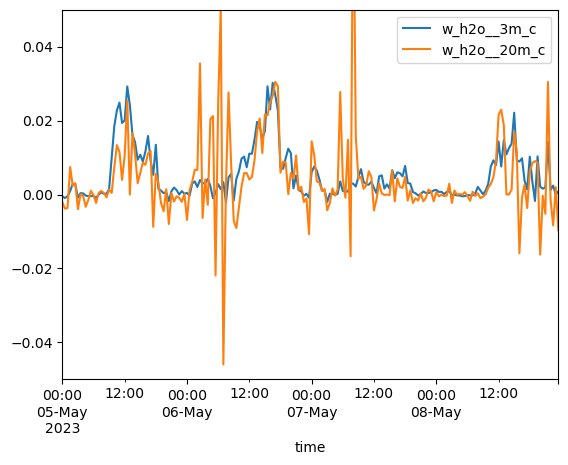

In [185]:
src.set_index('time').loc['20230505': '20230509'][['w_h2o__3m_c',	'w_h2o__20m_c',]].plot()
plt.ylim(-0.05,0.05)

### other stufff??

In [ ]:
daily_median_cycle.display(renderer='svg')

In [ ]:
advection_1d_fluxdensity_df.loc['20230401': '20230404'][[
    'w_h2o__3m_c',
    'vertical_advection_simple',
    # 'vertical_advection_complex',
    'lateral_advection'
]].plot()

In [ ]:


alt.Chart(
        advection_1d_df.loc['20230501': '20230519'].reset_index()
    ).transform_fold([
        'w_h2o__3m_c',
        # 'lateral_advection',
        # 'vertical_advection_complex',
        'lateral_advection_irga'
    ]).mark_line().encode(
        alt.X('time:T'),
        alt.Y('value:Q').title('Water vapor flux density (g/m^2/s)').scale(domain=[0,0.1], clamp=True),
        alt.Color('key:N').sort(['w_h2o__3m_c', 'kps-annex lateral advection'])
    ).properties(width=800, height=200)

In [ ]:
advection_1d_df.assign(lateral_advection = advection_1d_df.lateral_advection*7).loc['20230601': '20230619'].reset_index()

In [ ]:
snowdepth_df = pd.DataFrame({
    'kps snow depth': (tidy_df.query("variable=='SnowDepth_c'").set_index('time').loc['20230501': '20230530'].value*100),
    'annex snow depth': (annex_snowdepth_ds.to_dataframe().sort_index().loc['20230501': '20230530'].snow_depth).resample('30Min').mean()
})
snowdepth_df

In [ ]:
(
    alt.Chart(
        advection_1d_df.assign(lateral_advection = advection_1d_df.lateral_advection*7).loc['20230501': '20230530'].reset_index()
    ).transform_fold([
        'w_h2o__3m_c',
        'lateral_advection',
        # 'vertical_advection_complex',
        # 'lateral_advection_irga'
    ]).transform_window(
        rolling_avg = 'mean(value)',
        frame=[-2,2],
        groupby=['key']
    ).mark_line().encode(
        alt.X('time:T').axis(labels=False).title(None),
        alt.Y('rolling_avg:Q').title('Water vapor flux density (g/m^2/s)'),
        alt.Color('key:N').sort(['w_h2o__3m_c', 'kps-annex lateral advection'])
    ).properties(width=700, height=200)
    &
    alt.Chart(snowdepth_df.reset_index()).mark_line().transform_fold([
        'kps snow depth', 'annex snow depth'
    ]).mark_line().encode(
        alt.X('time:T'),
        alt.Y('value:Q').title('Snow depth (cm)'),
        alt.Color('key:N')
    ).properties(width=700, height=200)
).resolve_scale(x='shared', color='independent').display(renderer='svg')

In [ ]:
alt.Chart(
    advection_1d_df.assign(lateral_advection = advection_1d_df.lateral_advection*7).loc['20230601': '20230630'].reset_index()
).transform_fold([
    'w_h2o__3m_c',
    'lateral_advection',
    # 'vertical_advection_complex',
    # 'lateral_advection_irga'
]).transform_window(
    rolling_avg = 'mean(value)',
    frame=[-0,0],
    groupby=['key']
).mark_line().encode(
    alt.X('time:T'),
    alt.Y('rolling_avg:Q').title('Water vapor flux density (g/m^2/s)'),
    alt.Color('key:N').sort(['w_h2o__3m_c', 'kps-annex lateral advection'])
).properties(width=700, height=200)

In [ ]:


alt.Chart(
        advection_1d_df.assign(lateral_advection = advection_1d_df.lateral_advection*7).loc['20230601': '20230619'].reset_index().dropna()
    ).transform_fold([
        'w_h2o__3m_c',
        'lateral_advection',
        # 'vertical_advection_complex',
        # 'lateral_advection_irga'
    ]).mark_line().encode(
        alt.X('time:T'),
        alt.Y('value:Q').title('Water vapor flux density (g/m^2/s)'),
        alt.Color('key:N').sort(['w_h2o__3m_c', 'kps-annex lateral advection'])
    ).properties(width=600, height=200)

In [ ]:


alt.Chart(
        advection_1d_df.assign(lateral_advection = advection_1d_df.lateral_advection*7).loc['20230601': '20230619'].reset_index().dropna()
    ).transform_fold([
        'w_h2o__3m_c',
        'lateral_advection',
        # 'vertical_advection_complex',
        # 'lateral_advection_irga'
    ]).mark_line().encode(
        alt.X('time:T'),
        alt.Y('value:Q').title('Water vapor flux density (g/m^2/s)'),
        alt.Color('key:N').sort(['w_h2o__3m_c', 'kps-annex lateral advection'])
    ).properties(width=600, height=200)

# Data exploration

## Compare IRGA and Hygrometer measurements

In [ ]:
comparison_df = pd.concat([
    (1000*tidy_df[tidy_df.measurement=='specific humidity'].set_index(['time','height','tower', 'measurement'])),
    tidy_df[tidy_df.measurement=='air density'].set_index(['time','height','tower', 'measurement']),
    tidy_df[tidy_df.measurement=='Water vapor density'].set_index(['time','height','tower', 'measurement'])
])[['value']]
comparison_df = comparison_df.reset_index().pivot_table(values='value', columns='measurement', index=['time','height','tower'])
comparison_df ['Water vapor density (hygr)'] = comparison_df['air density'] * comparison_df['specific humidity']
comparison_df = comparison_df.rename(columns={'Water vapor density': 'Water vapor density (irga)'})
comparison_df

In [ ]:
import math 

src = comparison_df.loc[:,3,'c'].reset_index()
# max_val = math.ceil(
#     src[['Water vapor density (hygr)', 'Water vapor density (irga)']].dropna().values.max()
# )
max_val = 7
line = pd.DataFrame({
    'Goals Conceded': [0, max_val],
    'Goals': [0, max_val],
})

arr = np.array([0, max_val] * (len(src) // 2))
if len(arr) < len(src):
    src['one'] = list(arr) + [0]
    src['onetoone'] = list(arr) + [0]
else:
    src['one'] = list(arr)
    src['onetoone'] = list(arr)

line_plot = alt.Chart().mark_line(color= 'grey').encode(
    alt.X('one', title=''),
    alt.Y('onetoone', title='')
)
scatter_plot = alt.Chart().mark_rect().encode(
    alt.X('Water vapor density (hygr):Q').scale(domain = [0, max_val], clamp=True).bin(maxbins=75).axis(values=[0,1,2,3,4,5,6,7]).title('Water vapor density (hygr)'),
    alt.Y('Water vapor density (irga):Q').scale(domain = [0, max_val], clamp=True).bin(maxbins=75).axis(values=[0,1,2,3,4,5,6,7]).title('Water vapor density (irga)'),
    alt.Color('count()'),
).properties(width=200, height=200)

src['diff'] = (src.set_index('time')['Water vapor density (irga)'] - src.set_index('time')['Water vapor density (hygr)']).values

from sklearn.metrics import r2_score
meanerror_by_month = round(src.groupby(src.time.dt.month).mean().drop(columns='time')['diff'], 3)
r2_by_month = round(src.groupby(src.time.dt.month)[[
    'Water vapor density (hygr)', 'Water vapor density (irga)'
]].apply(
    lambda df: r2_score(df.dropna()['Water vapor density (hygr)'], df.dropna()['Water vapor density (irga)'])
), 3)

def r2_plot(month, title):
    return alt.layer(
        scatter_plot,
        line_plot,
        data=src[(src.time.dt.month == month)]
    ).properties(title=f'{title} (ME: {meanerror_by_month.loc[month]}, R2: {r2_by_month.loc[month]})')

(
    r2_plot(11, 'Nov.') | r2_plot(12, 'Dec.') | r2_plot(1, 'Jan.') | r2_plot(2, 'Feb.') | r2_plot(3, 'Mar.') | r2_plot(4, 'Apr.') | r2_plot(5, 'May') | r2_plot(6, 'June')
) & (
    alt.layer(
        alt.Chart().mark_rule().transform_calculate(
            y = '0'
        ).mark_rule().encode(alt.Y('y:Q')),
        alt.Chart().mark_line().encode(
            alt.X('hoursminutes(time):T'),
            alt.Y('mean(diff):Q').title('Mean difference (irga - hygr) (g/m^3)'),
        ),
        data = src[(src.time.dt.month != 10)]
    ).properties(width=230, height=230).facet(
        column=alt.Column('month(time):T', sort=[11,12,1,2,3,4,5,6])
    )  
)

## Examine daily cycles in vertical wind speed, hygrometer humidity, and irga humidity

In [ ]:
alt.Chart(
    tidy_df[tidy_df.variable.isin([
        'w_2m_c', 'w_3m_c', 'w_5m_c', 'w_10m_c', 'w_15m_c', 'w_20m_c',
    ])]
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q').title('Wind speed (m/s)'),
    alt.Color('height:O').scale(scheme='sinebow'),
    alt.Row('tower:N'),
    tooltip='height',
).properties(width = 200, height = 200, title='Vertical wind speed') | alt.Chart(
    tidy_df[tidy_df.variable.isin(['mixingratio_2m_c', 'mixingratio_3m_c', 'mixingratio_5m_c', 'mixingratio_10m_c', 'mixingratio_15m_c', 'mixingratio_20m_c',])]
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q').title('Water vapor mixing ratio (g/g)').scale(zero=False),
    alt.Color('height:O'),
    tooltip='height',
).properties(width = 200, height = 200, title='Hygrometer mixing ratio') | alt.Chart(
    tidy_df[tidy_df.variable.isin(['h2o_2m_c', 'h2o_3m_c', 'h2o_5m_c', 'h2o_10m_c', 'h2o_15m_c', 'h2o_20m_c',])]
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q').title('Absolute humidity (g/m^3)').scale(zero=False),
    alt.Color('height:O'),
    tooltip='height',
).properties(width = 200, height = 200, title='IRGA absolute humidity')

In [ ]:
import altair as alt
alt.Chart(
    tidy_df[tidy_df.variable.isin([
        'w_2m_c', 'w_3m_c', 'w_5m_c', 'w_10m_c', 'w_15m_c', 'w_20m_c',
    ])]
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('value:Q'),
    alt.Color('variable')
)